In [1]:
!pip install stanza
!pip install fasttext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
%matplotlib inline

import time
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import random
import stanza
import re

In [3]:
import sklearn
sklearn.__version__
from sklearn.utils import class_weight
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import decomposition, ensemble
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn import neighbors
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_validate
from sklearn.linear_model import SGDClassifier

In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.utils import np_utils

In [5]:
import itertools
from textblob import TextBlob 
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier
sns.set(style="darkgrid")

In [6]:
random.seed(42)

In [7]:
import string
import fasttext
from tqdm import tqdm

# ---- Call tqdm to see progress bar with pandas
tqdm().pandas()

0it [00:00, ?it/s]


In [8]:
class PreProcessing(object):
    '''
    Class to preprocess text
    
    '''
    
    
    def __init__(self):
        #print("Welcome in the preprocessing")
        pass
    
    @classmethod    
    def detect_lang_google(self, x):
        '''
        Function to detect the language of the string
        @param x: (str) sentences of text to detect language
        @return: (str or nan) language of the sentence
        '''
        translate = Translator()
        try:
            return translate.detect(x).lang
        except:
            return np.nan
    
    @classmethod
    def remove_numbers(self, text):
        '''
        Function to remove number in text.
        @param text: (str) sentence
        @return: (str) clean text
        '''
        text = ''.join([i for i in text if not i.isdigit()])         
        return text
    
    @classmethod
    def remove_URL(self, text):
        '''
        Function to remove url from text.
        @param text: (str) sentence
        @return: (str) clean text
        
        '''
        url = re.compile(r'https?://\S+|www\.\S+')
        return url.sub(r'',text)
    
    @classmethod
    def remove_html(self, text):
        '''
        Function regex to clean text from html balises.
        @param text: (str) sentence 
        @return: (str) clean text 
        '''
        html=re.compile(r'<.*?>')
        return html.sub(r'',text)
    
    
    @classmethod
    def remove_emoji(self, text):
        '''
        Function to remove emojis, symbols and pictograms etc from text
        @param text: (str) sentences 
        @return: (str) clean text 
        '''
        emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', text)
    
    
    @classmethod
    def preprocess(self, text):
        '''
        Function to remove special characters
        @param text: (pandas dataframe) text
        @return: (pandas dataframe) clean text 
        '''
        text = text.replace("(<br/>)", "")
        text = text.replace('(<a).*(>).*(</a>)', '')
        text = text.replace('(&amp)', '')
        text = text.replace('(&gt)', '')
        text = text.replace('(&lt)', '')
        text = text.replace('(\xa0)', ' ')  
        text = text.replace("\n", " ")
        text = text.replace("\x92", "'")
        return text
    
    @classmethod
    def remove_char_specific(self, text):
        '''
        Function to remove specific characters
        @param text: (str) text
        @return: (str) text without specific characters
        '''
        table = '!"#$%&()*+,./:;<=>?@[\]^_`{|}~•'
        table = str.maketrans(' ', ' ', table)
        words = text.split()
        stripped = [w.translate(table) for w in words]
        return ' '.join(stripped)
    
    @classmethod
    def remove_upper_case(self, text):
        '''
        Function to transform upper string in title words
        @param text: (str) text 
        @return: (str) text without upper words 
        '''
        words = text.split()
        stripped = [w.title() if w.isupper() else w for w in words]
        return " ".join(stripped)
    
    @classmethod
    def remove_stop_words(self, x, stop_word):
        '''
        Function to remove a list of words
        @param x : (str) text 
        @param stop_word: (list) list of stopwords to delete 
        @return: (str) new string without stopwords 
        '''
        x_new = text_to_word_sequence(x)    # tokenize text 
        x_ = []
        for i in x_new:
            if i not in stop_word:
                x_.append(i)
        return " ".join(x_)
    
    @classmethod
    def get_top_n_words(self, corpus, n=None):
        '''
        Function to return a list of most frequent unigrams in documents
        @param corpus: (str or pandas.dataframe) documents 
        @param n: (int) number of most frequent unigrams
        @return: (list) most frequent unigrams
        '''
        vec = CountVectorizer().fit(corpus)             # bag of words
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0)  
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:n]
    
    @classmethod
    def get_top_n_words_sw(self, corpus, stop_word=None, lang="fr", n=None):
        '''
        Function to return a list of most frequent unigrams in documents
        @param corpus: (str or pandas.dataframe) documents 
        @param stop_word: (list) list containing stopwords
        @param lang: (str) language of the text
        @param n: (int) number of most frequent unigrams
        @return: (list) most frequent unigrams
        '''
        if lang=="fr":
            corpus = corpus.apply(lambda x: self.remove_stop_words(x, stop_word))
        vec = CountVectorizer(stop_words = "english").fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:n]
    
    @classmethod
    def get_top_n_bigram(self, corpus, n=None):
        '''
        Function to return a list of most frequent bigrams in documents
        @param corpus: (str or pandas.dataframe) documents 
        @param n: (int) number of most frequent unigrams
        @return: (list) most frequent unigrams
        '''
        vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus) 
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:n]
    
    @classmethod
    def get_top_n_bigram_sw(self, corpus, stop_word=None, lang="fr", n=None):
        '''
        Function to return a list of most frequent bigrams in documents
        @param corpus: (str or pandas.dataframe) documents 
        @param stop_word: (list) list containing stopwords
        @param lang: (str) language of the text
        @param n: (int) number of most frequent unigrams
        @return: (list) most frequent unigrams
        '''
        if lang=="fr":
            corpus = corpus.apply(lambda x: self.remove_stop_words(x, stop_word))
        vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:n]
    
    @classmethod
    def get_top_n_trigram(self, corpus, n=None):
        '''
        Function to return a list of most frequent trigrams in documents
        @param corpus: (str or pandas.dataframe) documents 
        @param n: (int) number of most frequent unigrams
        @return: (list) most frequent unigrams
        '''
        vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:n]

    @classmethod
    def get_top_n_trigram_sw(self, corpus, stop_word=None, lang="fr", n=None):
        '''
        Function to return a list of most frequent trigrams in documents
        @param corpus: (str or pandas.dataframe) documents 
        @param stop_word: (list) list containing stopwords
        @param lang: (str) language of the text
        @param n: (int) number of most frequent unigrams
        @return: (list) most frequent unigrams
        '''
        if lang=="fr":
            corpus = corpus.apply(lambda x: self.remove_stop_words(x, stop_word))
        vec = CountVectorizer(ngram_range=(3, 3), stop_words="english").fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:n]
    
    @classmethod
    def get_top_n_5grams_sw(self, corpus, stop_word=None, lang="fr", n=None):
        '''
        Function to return a list of most frequent trigrams in documents
        @param corpus: (str or pandas.dataframe) documents 
        @param stop_word: (list) list containing stopwords
        @param lang: (str) language of the text
        @param n: (int) number of most frequent unigrams
        @return: (list) most frequent unigrams
        '''
        if lang=="fr":
            corpus = corpus.apply(lambda x: self.remove_stop_words(x, stop_word))
        vec = CountVectorizer(ngram_range=(5, 5), stop_words="english").fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:n]

In [9]:
class Metrics(object):
    '''
    Class containing functions to plot the different metric curves (Precision-Recall, ROC AUC etc...)
    '''
    
    def __init__(self):
        '''
        Initialisation of the class'''
        
        

    @classmethod 
    def roc_auc_curve(self, model, x, y, labels, gb=False):
        '''
        Function to plot the ROC AUC curves for binary or multiclass classification. 
        Correct for standard machine learning models and Neural Networks. 
        @param model: (model) classification model
        @param x: (list) validation sample
        @param y: (list int) validation sample label
        @param gb: (bool) inform if the model is an ensemble model 
        '''
        # generate a no skill prediction (majority class)
        ns_probs = [0 for _ in range(len(y.reshape(-1, 1)))]
        # predict probabilities
        if gb: # test if ensemble model 
            lr_probs = model.predict_proba(x)
        else:    
            lr_probs = model.predict(x)
        
        plt.figure(figsize=(10,8))
        if len(labels)==2: # binary classification 
            if gb:
                # compute area under the roc curve
                lr_auc = roc_auc_score(y, lr_probs[:,1], average="weighted")
            else:
                lr_auc = roc_auc_score(y, lr_probs, average="weighted")
            # Compute no skill roc curve 
            ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
            # plot the curve no skill
            plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
            if gb: # test if the model is an ensemble model
                # compute ROC curve
                lr_fpr, lr_tpr, _ = roc_curve(y, lr_probs[:,1])
            else:
                # compute ROC curve
                lr_fpr, lr_tpr, _ = roc_curve(y, lr_probs)

            # plot the roc curve for the model
            plt.plot(lr_fpr, lr_tpr, label=f'Class (area {round(lr_auc,3)})')
                # axis labels
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
                # show the grid
            plt.grid(True)
                # show the legend
            plt.legend()
        else: # multilabel classification 
            dummy_y = np_utils.to_categorical(y)
            #ns_auc = roc_auc_score(valid_y, dummy_ns, average="weighted", multi_class="ovr")

            lr_auc_multi = []
            for i in enumerate(labels):
                lr_auc_multi.append(round(roc_auc_score(dummy_y[:,i[0]], lr_probs[:,i[0]], average="weighted"),3))
                print(f"ROC AUC class {i[1]}: {lr_auc_multi[-1]}")
            lr_auc = roc_auc_score(dummy_y, lr_probs, average="weighted", multi_class="ovr" )

            ns_fpr, ns_tpr = [i/10 for i in list(range(0, 11, 1))], [i/10 for i in list(range(0, 11, 1))] #f(range(0, 0.1, 1))
            plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
            for i in range(lr_probs.shape[1]):
                lr_fpr, lr_tpr, _ = roc_curve(dummy_y[:,i], lr_probs[:,i])
                # plot the roc curve for the model
                plt.plot(lr_fpr, lr_tpr, label=f'Class {labels[i]} (area {lr_auc_multi[i]})')
                # axis labels
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                # show the grid
                plt.grid(True)
                # show the legend
                plt.legend()
                
        print('\nROC AUC=%.3f \n' % (lr_auc))
        plt.show()

    @classmethod 
    def confusion_matrix(self, model, y, x, labels):
        '''
        Compute the confusion matrix for binary or multiclass classification. 
        Correct for standard machine learning models and Neural Networks. 
        @param model: (model) classification model
        @param x: (list) validation sample
        @param y: (list int) validation sample label
        
        '''
        if len(labels)==2: # binary confusion matrix
            confu_matrix = pd.DataFrame(confusion_matrix(y, (model.predict(x) > 0.5).astype(int)), \
                 columns=['Predicted Negative', "Predicted Positive"], index=['Actual Negative', 'Actual Positive'])
            print(confu_matrix)
            return confu_matrix
        else:
            # multiclass confusion matrix
            dummy_y = np_utils.to_categorical(y)
            mcm = multilabel_confusion_matrix(dummy_y, np_utils.to_categorical(model.predict(x).argmax(-1)))
            df_mcm = pd.DataFrame()
            for i in zip(mcm, labels): # compute confusion matrix for each class 
                mcm = pd.DataFrame(data=i[0], columns=['Predicted Negative', "Predicted Positive"], index=['Actual Negative', 'Actual Positive'])
                df_mcm = df_mcm.append(mcm)
                print("\nConfusion matrix for classe: %s \n" %(i[1]))
                print(mcm)
                print("\n")
            return df_mcm
        
    @classmethod 
    def precision_recall_curve(self, model, x, y, labels, gb=False):
        '''
        Function to plot the recall precision curves for binary or multiclass classification. 
        Correct for standard machine learning models and Neural Networks. 
        @param model: (model) classification model
        @param x: (list) validation sample
        @param y: (list int) validation sample label
        @param gb: (bool) inform if the model is an ensemble model 
        '''
        # predict probabilities
        if gb: # test if the model is an ensemble model 
            lr_probs = model.predict_proba(x)
        else:
            lr_probs = model.predict(x)

        print("\n")
        plt.figure(figsize=(10,8))

        if len(labels)==2: # binary classification 
            if gb:
                precision, recall, thresholds = precision_recall_curve(y, lr_probs[:,1]) # compute precision recall curve 
                lr_f1 = f1_score(y,(lr_probs[:,1]>0.5).astype(int))
            else:
                precision, recall, thresholds = precision_recall_curve(y, lr_probs)
                lr_f1 = f1_score(y,(lr_probs>0.5).astype(int))
            
            # calculate precision-recall AUC
            lr_auc = auc(recall, precision)
            # summarize scores
            print('Model: f1-score=%.3f AUC=%.3f' % (lr_f1, lr_auc)) # print f1-score and auc 
            plt.plot(recall, precision, marker='.', label='Model')
            no_skill = len(y[y==1]) / len(y)
            plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
        else:
            dummy_y = np_utils.to_categorical(y)
            dummy_lr = np_utils.to_categorical(lr_probs.argmax(-1))
            for i in enumerate(labels):
                precision, recall, thresholds = precision_recall_curve(dummy_y[:,i[0]], lr_probs[:,i[0]])
                # calculate precision-recall AUC
                lr_f1 = f1_score(dummy_y[:,i[0]], dummy_lr[:,i[0]]) 
                lr_auc = auc(recall, precision)
                # summarize scores
                print('Model class: %s --> f1-score=%.3f AUC=%.3f' % (i[1], lr_f1, lr_auc))
                plt.plot(recall, precision, label='Class %s' %(i[1]))
            no_skill = len(y[y>=1]) / len(y)
            plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
        # plot the precision-recall curves
        print("\n")

        # axis labels
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        # show the legend
        plt.legend()
        # show the grid
        plt.grid(True)
        # show the plot
        plt.show()

    @classmethod 
    def plot_eval_xgb(self, model, labels):
        '''
        Function to plot the evaluation curves for xgboost models 
        @param model: (model) xgboost model
        @param labels: (list) list ocntaining the labels in string 
        '''
        # retrieve performance metrics
        results = model.evals_result()
        if len(labels)>2: # multiclass 
            log_ = "mlogloss"
            error_= "merror"
        else: # binary classifiation
            log_ = "logloss"
            error_= "error"

        # create axis x with the number of epochs
        epochs = len(results['validation_0'][error_])
        x_axis = range(0, epochs)

        plt.figure(figsize=(15,10))
        plt.subplot(221)
        # Plot training & validation accuracy values
        plt.plot(x_axis, results['validation_0'][log_], label='Train')
        plt.plot(x_axis, results['validation_1'][log_], label='Test')
        plt.ylabel('Log Loss')
        plt.xlabel('Epochs')
        plt.title('XGBoost Log Loss')
        plt.legend(loc='upper left')
        plt.grid(True)


        # Plot training & validation loss values
        plt.subplot(222)
        plt.plot(x_axis, results['validation_0'][error_], label='Train')
        plt.plot(x_axis, results['validation_1'][error_], label='Test')
        plt.legend()
        plt.ylabel('Classification Error')
        plt.xlabel('Epochs')
        plt.title('XGBoost Classification Error')
        plt.legend( loc='upper left')
        plt.grid(True)
        plt.show()
        
    @classmethod 
    def plot_confusion_matrix(self, cm, classes, normalized=True, cmap='bone'):
        '''
        Function to generate an heatmap of the confusion matrix
        @param cm: (matrix) confusion matrix
        @param classes: (list) list containing labels of the classes
        @param normalised: (bool) determined if the confusion matrix need to be normalized
        @param cmap: (str) color for the confusion matrix
        '''
        plt.figure(figsize=[10, 8])
        norm_cm = cm
        if normalized:
            norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            sns.heatmap(norm_cm, annot=cm, fmt='g', xticklabels=classes, yticklabels=classes, cmap=cmap)
            #plt.savefig('confusion-matrix.png')

    @classmethod
    def plot_history(self, history):
        '''
        Function to plot the learning curves of a neural network
        @param history: metrics of a neural network
        '''
        plt.figure(figsize=(15,10))
        plt.subplot(221)
        # Plot training & validation accuracy values
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.grid(True)


        # Plot training & validation loss values
        plt.subplot(222)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.grid(True)
        plt.show()
            
            
    @classmethod
    def metrics_deep_learning(self, model, history, x, y, labels):
        '''
        Function to plot the different metrics for the deep learning algorithms.
        @param model: (tensorflow.python.keras.engine.sequential.Sequential) deep learning model
        @param history: (tensorflow.python.keras.callbacks.History) history of the training model
        @param x: (numpy.ndarray) x data
        @param y: (numpy.ndarray) target data
        @param labels: (list) list containing the labels in str  
        '''
        self.plot_history(history)
        if len(labels)==2:

            print(classification_report(y, (model.predict(x) > 0.5).astype(int), target_names=labels))
            print(f"\nThe balanced accuracy is : {round(100*balanced_accuracy_score(y, (model.predict(x)>0.5).astype(int)),2)}%\n")
            print(f"\nThe Zero-one Loss is : {round(100*zero_one_loss(y, (model.predict(x)>0.5).astype(int)),2)}%\n")
            print(f"\nExplained variance score: {round(explained_variance_score(y, (model.predict(x)>0.5).astype(int)),3)}\n" )
            self.roc_auc_curve(model, x, y, labels)
            self.precision_recall_curve(model, x, y, labels)

            print(f"\nCohen's kappa: {round(100*cohen_kappa_score(y, (model.predict(x) > 0.5).astype(int) ),2)}% \n") 
            #matrices = self.confusion_matrix(model, y, x, labels)
            cm = confusion_matrix(y, (model.predict(x) > 0.5).astype(int))

            print("\nConfusion Matrix\n")
            self.plot_confusion_matrix(cm, labels)
        else:

            print(f"\nThe balanced accuracy is : {round(100*balanced_accuracy_score(y, model.predict(x).argmax(axis=-1)),2)}%\n")
            print(f"\nThe Zero-one Loss is : {round(100*zero_one_loss(y, model.predict(x).argmax(axis=-1)),2)}%\n")
            print(f"\nExplained variance score: {round(explained_variance_score(y, model.predict(x).argmax(axis=-1)),3)}\n" ) 
            self.roc_auc_curve(model, x, y, labels)
            self.precision_recall_curve(model, x, y, labels)

            print(f"\nCohen's kappa: {round(100*cohen_kappa_score(y, model.predict(x).argmax(axis=-1) ),2)}%\n")
            #matrices = self.confusion_matrix(model, y, x, labels)
            cm = confusion_matrix(y, model.predict(x).argmax(axis=-1))

            print(classification_report(y, model.predict(x).argmax(axis=-1), target_names=labels))

            print("\nConfusion Matrix\n")
            self.plot_confusion_matrix(cm, labels)

In [10]:
def extract_features(self, df, column):
        '''
        Function to extract information and generate dataframe columns. The goal is to extract
        mail informations as: Id of the courriel, the sender, the receiver, the subject, the date of sending
        @param df: (pandas dataframe) dataframe containing all the data
        @param column: (str) the column containing the mails
        @return: (pandas dataframe) dataframe with the original text, the text without the header and columns containing information
        '''
        # ---- make some empty lists
        text_ = []
        sender_ = []
        dest_ = []
        subject_ = []
        date_ = []
        id_mail_ = []
        phone_ = []
        # ---- Save the original text
        df.loc[:, column+"_brut"] = df.loc[:,column]
        # ---- For each text the loop will extract informations, store them into lists and delete the corresponding text
        for text in tqdm(df[column]):
            _text = text.replace("\t", " ").split("\n")
            text = []
            # ---- Clean extra space 
            for line in _text:
                text.append(self.remove_whitespace(line))
            sender = []
            dest = []
            subject = []
            date = []
            ind = []
            id_mail = []
            for i, lines in enumerate(text):
                 
                if any(x in lines for x in ["Id Courriel"]):                       # ---- Looking for Id 
                    _text = lines.split(":")
                    if len(_text)>1:
                        id_mail.append(' '.join(_text[1:]))
                    else:
                        id_mail.append(_text[1])
                    ind.append(i)

                if any(x in lines for x in ["De:","De :", "From:", "From :"]):     # ---- Looking for sender
                    _text = lines.split(":")
                    if len(_text)>1:
                        sender.append(' '.join(_text[1:]))
                    else:
                        sender.append(_text[1])
                    ind.append(i)
                    
                if  any(x in lines for x in ["À :", "À:","à:", "à :", "To:", \
                                             "To :","to:", "to :", "CC:", "CC :", \
                                             "cc:", "cc :"]):                       # ---- Looking for receiver
                    _text = lines.split(":")
                    if len(_text)>1:
                        dest.append(' '.join(_text[1:]))
                    else:
                        dest.append(_text[1])
                    ind.append(i)
                    
                if  any(x in lines for x in ["Subject", "Objet", "objet:", \
                                             "objet :"]) :                          # ---- Looking for the subject
                    _text = lines.split(":")
                    if len(_text)>1:
                        subject.append(' '.join(_text[1:]))
                    else:
                        try:
                            subject.append(_text[1])
                        except:
                            subject.append(np.nan)
                    ind.append(i)
                    
                if  any(x in lines for x in ["Envoyé:", "Envoyé :", "Envoyé le ", \
                                             "Date:", "Date :"]):                    # ---- Looking for sending date
                    _text = lines.split(":")
                    if len(_text)>1:
                        date.append(':'.join(_text[1:]))
                    else:
                        date.append(_text[1])
                    ind.append(i)   
            
            # ---- If there is information to delete inside the text
            if ind:
                try:
                    for i in ind[::-1]:
                        del text[i]
                except:
                    pass 
                
            text = '\n'.join(map(str, text))
            # ---- Remove phone number
            text, phone = self.remove_phone_number(text) 

            # ---- Check if some lists are empty
            if not phone: phone.append(np.nan)
            if not id_mail: id_mail.append(np.nan)
            if not sender: sender.append(np.nan)
            if not dest: dest.append(np.nan)
            if not date: subject.append(np.nan)

            # ---- Stack the different informations 
            phone_.append(','.join(map(str, phone)))
            text_.append(text )
            sender_.append(' '.join(map(str, sender)))
            dest_.append(','.join(map(str, dest)))
            subject_.append(','.join(map(str, subject )))
            date_.append(','.join(map(str, date )))
            id_mail_.append(','.join(map(str, id_mail)))
        
        # ---- Construct the different columns 
        df.loc[:,column] = text_
        df.loc[:, "id_mail"] =  id_mail_
        df.loc[:, "From"] = sender_
        df.loc[:, "To"] = dest_
        df.loc[:, "Subject"] = subject_
        df.loc[:, "Date"] = date_
        df.loc[:, "Phone"] = phone_

        return df

In [11]:
 def remove_whitespace(self, text):
        """
        Function to remove extra whitespaces from text
        @param text: (str) text
        @return: (str) text clean from extra space
        """
        text = text.strip()
        return " ".join(text.split())

In [12]:
def remove_phone_number(self, x):
        '''
        Function to find and remove phone number with regex    
        @param x: (str) text 
        @return: (str) text without phone number
        '''
        # ---- Phone number 
        phone = []
        r = re.compile(r'(\d{3}[-\.\s]??\d{3}[-\.\s]??\d{4}|\(\d{3}\)\s*\d{3}[-\.\s]??\d{4}|\d{3}[-\.\s]??\d{4})') 
        for i in r.findall(x):
            phone.append(i)
            x = x.replace(i, ' ')
        return x , phone

In [13]:
def strip_text(self, text, sentence):
        '''
        Function to cut the text where the sentence is find and return the first part.
        Powerful to split the text from signature.
        @param text: (str) text
        @param sentence: (str) beginning of the signature
        @return: (str) first part of the text without the signature
        '''
        if sentence in text:
            text = text.split(sentence)[0]
        return text

In [14]:
def find_corres(self, text, list_words):
        '''
        Function to locate a word or list of words in a string.
        @param text: (str) text
        @param list_words: (str or list) word or list of words to find in the text
        @return: (bool) indicate if the text contained the list
        '''
        if type(list_words)==str:     # change string in list if one word is passed
            list_words=[list_words]
            
        results = []
        for i in list_words:
            if i in text:
                results.append(True)
            else:
                results.append(False)
        return True if sum(results)>0 else False

In [15]:
def remove_string(self, text, list_sentences):
        '''
        Function
        @param text: (str) text
        @param list_sentences: (list) list of sentences to be delete
        @return: (str) text without a list of sentences
        '''
        text = text.lower()
        for i in list_sentences:
            if text.find(i.lower()) != -1:           # ---- Looking for the substring 
                text = text.replace(i.lower(), ' ')
        return text
def find_nearest(self, array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return array[idx]


def compare_distance_word(self, index, list_ref):
        res = [[self.find_nearest( j, i) for j in index ] for i in list_ref] # find nearest value taking the smallest list into account
        idx = [all((t - s)<=5 for s, t in zip(i, i[1:])) for i in res]  # check if the each is seperate by maximum 5 words
        res = [x for x, y in zip(res, idx) if y == True]                # select lists where each words are closed
        return res

In [16]:
preproc = PreProcessing()
Metric = Metrics()

In [17]:
def load_text(path, n, label):
  x = []
  for i in range(n):
    T = ""
    with open(str(path + str(i+1)+'.txt')) as f:
      lines = f.readlines()
      for e in lines:
        T = T + e
    x.append(T)
  L = np.zeros(len(x))
  if(label == 1):
    L = np.ones(len(x))
  return x, L

In [18]:
p = ['/content/drive/MyDrive/Mini Project/Dataset/Text/Non Abusive/Non-Abusive-',
     '/content/drive/MyDrive/Mini Project/Dataset/Text/Abusive/Abusive-']
N = [40, 47]
L = [0, 1]
Text_nab, Lbl_nab = load_text(p[0] ,N[0], L[0])
Text_ab, Lbl_ab = load_text(p[1], N[1], L[1])

In [19]:
Text = Text_nab + Text_ab
Lbl = np.concatenate((Lbl_nab, Lbl_ab), axis = 0)
len(Text), len(Lbl)

(87, 87)

In [20]:
df = pd.DataFrame(data=[Text, Lbl], index=["text", "label"]).T
df

,text,label
0,இப்போ ரிசெண்டஹ் சென்னைல ஒரு பர்டிகுலர் கடைக்கு...,0.0
1,ஒரு நிமிஷம் மெல்ல தளிடாதிங்க நான் வந்து டிஃடோக...,0.0
2,சமீபத்தில வெள்ளியிருக்க வலிமை திரைப்படம் அழியன...,0.0
3,இந்த பாருங்க எல்லாரும் பொறுமையா லைன்ல வந்து கு...,0.0
4,மாஸ்ன என்ன அது உண்மையான மாஸ் நம்ம பண்றது எல்லா...,0.0
...,...,...
82,இப்படி கண்ட கண்ட பாடலை அட்வைஸ் பண்ணாலும் கடைசி...,1.0
83,நாம் அனைவரும் வாழ்த்த பிறந்தவர்கள் வாழ்க்கையை ...,1.0
84,இது என்ன இன்று முளைத்த சொல்லலா இல்லை நூற்றாண்ட...,1.0
85,ஓல் மிகச்சாதாரணமாக வருவது கிடையாது. சில சந்தர்...,1.0


In [21]:
df.shape

(87, 2)

**Pre Processing**

In [22]:
df["text"] = df["text"].progress_apply(preproc.remove_URL)
df["text"] = df["text"].progress_apply(preproc.remove_html)
df["text"] = df["text"].progress_apply(preproc.remove_emoji)

print(df.head())

100%|██████████| 87/87 [00:00<00:00, 10815.83it/s]

                                                text label
0  இப்போ ரிசெண்டஹ் சென்னைல ஒரு பர்டிகுலர் கடைக்கு...   0.0
1  ஒரு நிமிஷம் மெல்ல தளிடாதிங்க நான் வந்து டிஃடோக...   0.0
2  சமீபத்தில வெள்ளியிருக்க வலிமை திரைப்படம் அழியன...   0.0
3  இந்த பாருங்க எல்லாரும் பொறுமையா லைன்ல வந்து கு...   0.0
4  மாஸ்ன என்ன அது உண்மையான மாஸ் நம்ம பண்றது எல்லா...   0.0


In [23]:
df['polarity'] = df["text"].map(lambda text: TextBlob(text).sentiment.polarity)

Text(0, 0.5, 'Number of text')

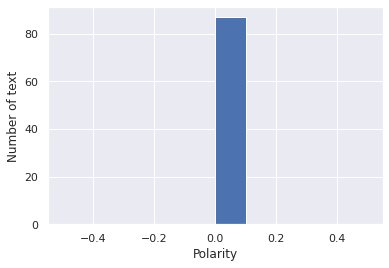

In [24]:
# ---- Show the polarities repartition
df['polarity'].hist()
plt.xlabel("Polarity")
plt.ylabel("Number of text")
#plt.savefig("polarity.png")

**Text Informations**

In [25]:
# ---- Extract statistics of the text 
df['char_count'] = df["text"].apply(len) # Number of characters in the string
df['word_count'] = df["text"].apply(lambda x: len(x.split())) # Number of words in the string 
df['word_density'] = df['char_count'] / (df['word_count']+1) # Density of word (in char)
df['punctuation_count'] = df["text"].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
df['title_word_count'] = df["text"].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()])) # Number of words containing upper letter in first place 
df['upper_case_word_count'] = df["text"].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))

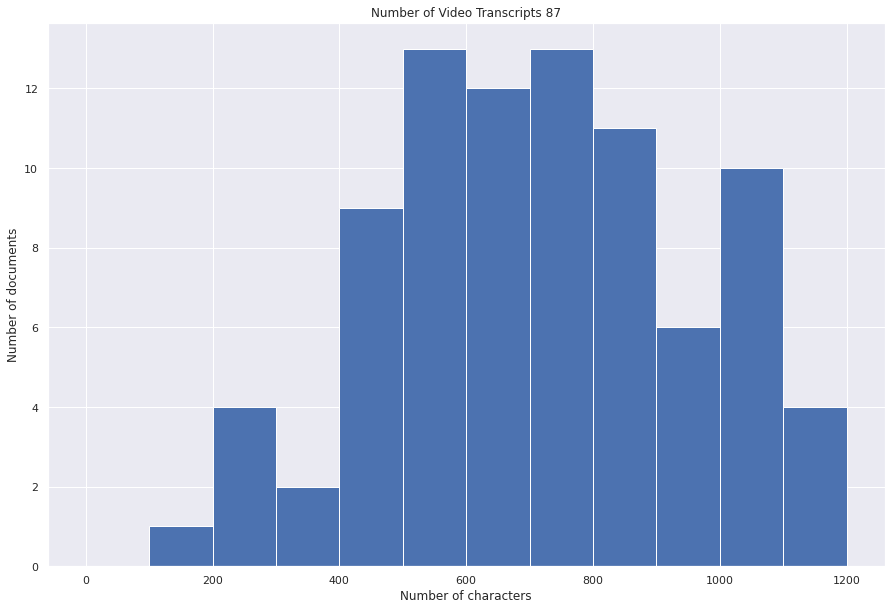

<Figure size 432x288 with 0 Axes>

In [26]:
# ---- Show the number of characters per document
plt.figure(figsize=(15,10))
max_x = 10000 if df.char_count.max()>10000 else df.char_count.max()
plt.hist(df.char_count.values, bins = range(0, max_x, 100))
plt.title(f"Number of Video Transcripts {df.shape[0]}")
plt.xlabel("Number of characters")
plt.ylabel("Number of documents")
plt.grid(True)
plt.show()
plt.savefig("numb_char.png")

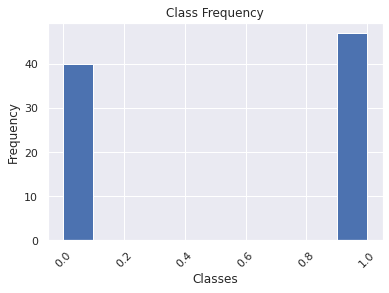

In [27]:
# ---- histogram of the class frequency
df["label"].hist(xrot=45)
plt.xlabel("Classes")
plt.ylabel("Frequency")
plt.title("Class Frequency")
plt.savefig("distrib_classes.png")

**N-grams**

Unigram

In [28]:
number = 20
common_words = preproc.get_top_n_words(df["text"], 20)
df1 = pd.DataFrame(common_words, columns = ['words' , 'count'])

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2984 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2990 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2949 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2965 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2994 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2997 missing from current font.
  font.set_text(s

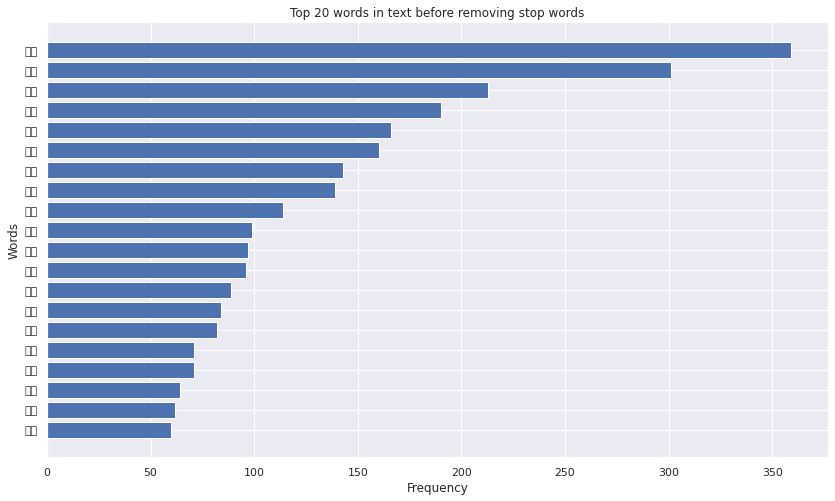

In [29]:
plt.figure(figsize=(14,8))
plt.barh(df1["words"][::-1], df1["count"][::-1])
plt.ylabel("Words")
plt.xlabel("Frequency")
plt.title("Top %d words in text before removing stop words" %(number))
plt.grid(True)

In [30]:
# The Y-axis values
# df1["words"][::-1]

Bi-Grams

In [31]:
number = 20
common_words = preproc.get_top_n_bigram(df["text"], number)
df2 = pd.DataFrame(common_words, columns = ['words' , 'count'])

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2950 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 2950 missing from current font.
  font.set_text(s, 0, flags=flags)


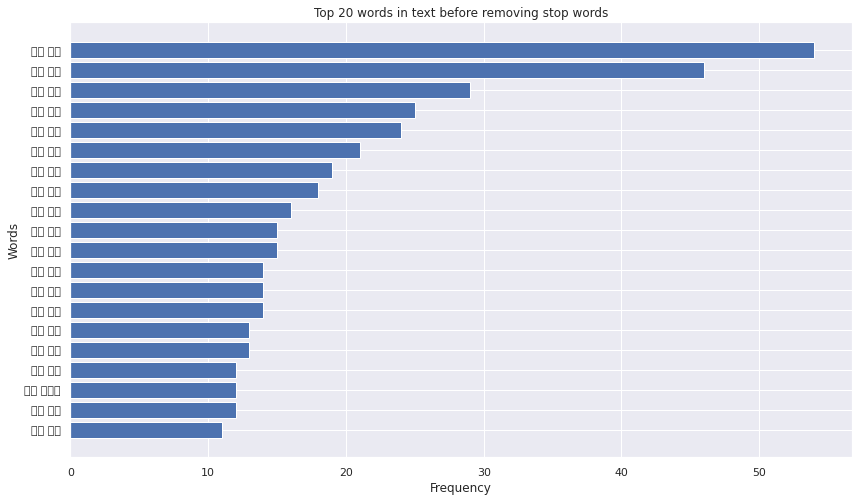

In [32]:
plt.figure(figsize=(14,8))
plt.barh(df2["words"][::-1], df2["count"][::-1])
plt.ylabel("Words")
plt.xlabel("Frequency")
plt.title("Top %d words in text before removing stop words" %(number))
plt.grid(True)

In [33]:
# Y-axis values
#df2["words"][::-1]

Tri-Grams

In [34]:
number = 20
common_words = preproc.get_top_n_trigram(df["text"], number)
df3 = pd.DataFrame(common_words, columns = ['words' , 'count'])

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 3000 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2999 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2991 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2974 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 3000 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 2999 missing from current font.
  font.set_text(s, 

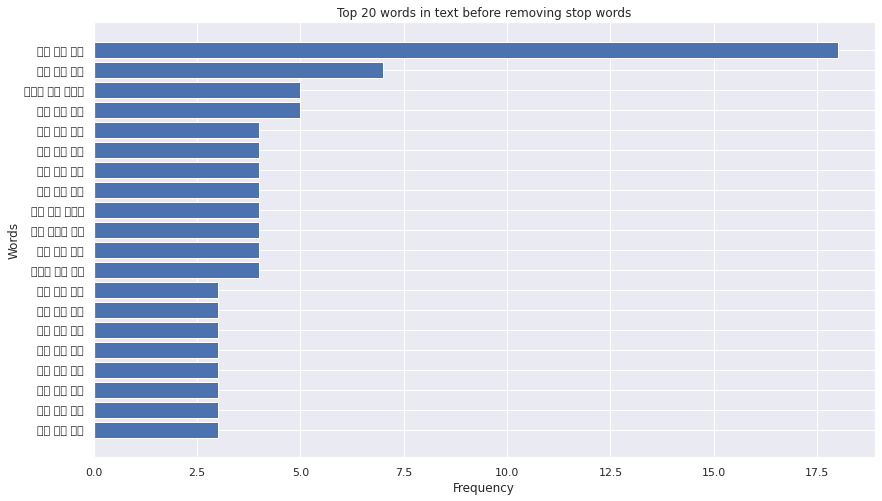

In [35]:
plt.figure(figsize=(14,8))
plt.barh(df3["words"][::-1], df3["count"][::-1])
plt.ylabel("Words")
plt.xlabel("Frequency")
plt.title("Top %d words in text before removing stop words" %(number))
plt.grid(True)
plt.savefig("trigrams.png")

In [36]:
# Y-axis values
#df3["words"][::-1]

In [37]:
from keras.preprocessing.text import text_to_word_sequence
df.loc[:,"text_sw"] = df.loc[:,"text"].progress_apply(lambda x : preproc.remove_stop_words(x, "/"))

100%|██████████| 87/87 [00:00<00:00, 4635.94it/s]


In [38]:
if df["text_sw"].isnull().sum()>0:
    print("Empty text")
    df["text_sw"][df["text_sw"].isnull()] = "empty_text"

In [39]:
# split the dataset into training and validation datasets 
# ML classic 
train_x_sw, valid_x_sw, y_train_sw, y_valid_sw = model_selection.train_test_split(df["text_sw"], df["label"], random_state=42, stratify=df["label"], test_size=0.2)

# For Embeddings
train_x, valid_x, y_train, y_valid = model_selection.train_test_split(df["text"], df["label"], random_state=42, stratify=df["label"], test_size=0.2)

# label encode the target variable 
encoder = preprocessing.LabelEncoder()
train_y_sw = encoder.fit_transform(y_train_sw)
valid_y_sw = encoder.fit_transform(y_valid_sw)
train_y = encoder.fit_transform(y_train)
valid_y = encoder.fit_transform(y_valid)

In [40]:
# Compute the class weight with sklearn 
class_weights = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(y_train),y = y_train)
print(*[f'Class weight: {round(i[0],4)}\tclass: {i[1]}' for i in zip(class_weights, np.unique(y_train))], sep='\n')

Class weight: 1.0781	class: 0.0
Class weight: 0.9324	class: 1.0


In [41]:
# Determined if the dataset is balanced or imbalanced 
ratio = np.min(df.label.value_counts()) / np.max(df.label.value_counts())
if ratio > 0.1:      # Ratio 1:10 -> limit balanced / imbalanced 
    balanced = True
    print(f"\nThe dataset is balanced (ratio={round(ratio, 3)})")
else:
    balanced = False
    print(f"\nThe dataset is imbalanced (ratio={round(ratio, 3)})")
    #from imblearn.over_sampling import ADASYN
    # put class for debalanced data 
    # in progress


The dataset is balanced (ratio=0.851)


In [42]:
# Keep the unique label corresponding to their encoding correspondance
labels = df["label"].unique()
test=pd.DataFrame(data=np.transpose([labels,encoder.fit_transform(labels)]), columns=["labels", "encoding"]).sort_values(by=["encoding"])
labels=test.labels.tolist()
if any(str(i).isdigit() for i in labels) and len(labels)==2:
    labels = ["Non-Abusive", "Abusive"]

In [43]:
%%time
# create a One-Hot encoding object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(df["text"]+"_sw")

# transform the training and validation data 
xtrain_count =  count_vect.transform(train_x_sw)
xvalid_count =  count_vect.transform(valid_x_sw)

CPU times: user 27.3 ms, sys: 16 µs, total: 27.3 ms
Wall time: 28 ms


In [44]:
%%time
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(df["text"])
xtrain_tfidf =  tfidf_vect.transform(train_x_sw)
xvalid_tfidf =  tfidf_vect.transform(valid_x_sw)
print("word level tf-idf done")
# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(df["text"])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x_sw)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_x_sw)
print("ngram level tf-idf done")
# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char',  ngram_range=(2,3), max_features=5000) 
tfidf_vect_ngram_chars.fit(df["text"])
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_x_sw) 
xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(valid_x_sw) 
print("characters level tf-idf done")

word level tf-idf done
ngram level tf-idf done
characters level tf-idf done
CPU times: user 352 ms, sys: 3.25 ms, total: 356 ms
Wall time: 364 ms


In [45]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import zero_one_loss
from sklearn.metrics import explained_variance_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
def metrics_ML(clf, X, Y, X_test, Y_test, labels, gb=False):
    '''
    Function to compute a classifier model
    @param X: (matrix) training x data
    @param y: (list) train labels - ground truth
    @param x_test: (matrix) matrix of test x data
    @param y_test: (list) list of test labels
    @return model_NB: (model) train model
    @return pred: (list) list of predicted labels
    @return end: (float) fit time of the model
    @return model.score(): (float) accuracy of the model
    '''
    model_, pred, time_train, score_ = classifier_model(clf, X, Y, X_test, Y_test)
    print("Execution time : %.3f s" %(time_train))
    print(f"Score : {round(100*score_,2)} %" )
    print("\nClassification Report\n")
    print(classification_report(Y_test, pred, target_names=labels))
    cm = confusion_matrix(Y_test, pred)
    print("\nConfusion Matrix\n")
    Metric.plot_confusion_matrix(cm, labels)
    print("\n")
    Metric.precision_recall_curve(model_,  X_test, Y_test, labels, gb=gb)
    print("\n")
    Metric.roc_auc_curve(model_,  X_test, Y_test, labels, gb=gb)
    print(f"\n\nCohen's kappa: {round(100*cohen_kappa_score(Y_test,  pred),2)}%\n\n")

In [46]:
def classifier_model(clf, X, y, x_test, y_test):
    '''
    Function to compute a classifier model
    @param clf: (model) classifier model
    @param X: (matrix) training x data
    @param y: (list) train labels - ground truth
    @param x_test: (matrix) matrix of test x data
    @param y_test: (list) list of test labels
    @return model_NB: (model) train model
    @return pred: (list) list of predicted labels
    @return end: (float) fit time of the model
    @return model.score(): (float) accuracy of the model
    '''
    
    start = time.time()
    clf.fit(X, y)
    end = time.time() - start
    pred = clf.predict(x_test)
    
    #accuracy = accuracy_score(y_test, pred)
    
    return clf, pred, end, clf.score(x_test, y_test)#, accuracy

Multinomial Naive Bayes for One-Hot Encoding



Multinomial Naive Bayes for One-Hot encoding

Execution time : 0.003 s
Score : 94.44 %

Classification Report

              precision    recall  f1-score   support

 Non_Abusive       1.00      0.88      0.93         8
     Abusive       0.91      1.00      0.95        10

    accuracy                           0.94        18
   macro avg       0.95      0.94      0.94        18
weighted avg       0.95      0.94      0.94        18


Confusion Matrix





Model: f1-score=0.952 AUC=0.921




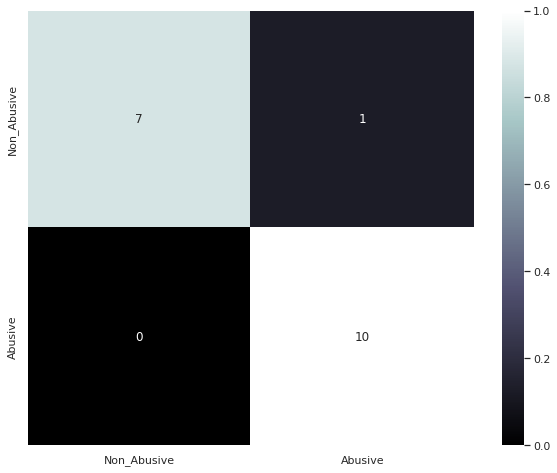

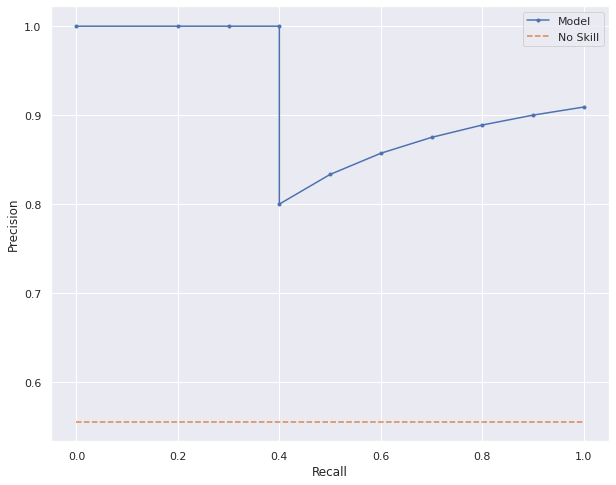




ROC AUC=0.925 



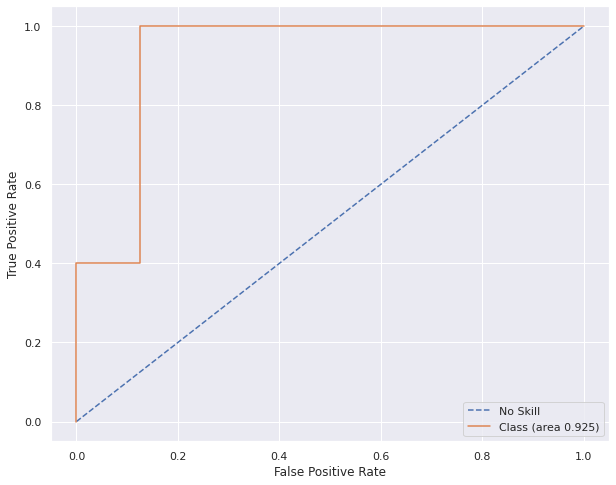



Cohen's kappa: 88.61%




In [47]:
LBL = ["Non_Abusive", "Abusive"]
print("\nMultinomial Naive Bayes for One-Hot encoding\n")
metrics_ML(naive_bayes.MultinomialNB(), xtrain_count, train_y_sw, xvalid_count, valid_y_sw, LBL, gb=True)

Multinomial Naive Bayes for TF-IDF


Multinomial Naive Bayes for TF-IDF

Execution time : 0.002 s
Score : 77.78 %

Classification Report

              precision    recall  f1-score   support

 Non_Abusive       1.00      0.50      0.67         8
     Abusive       0.71      1.00      0.83        10

    accuracy                           0.78        18
   macro avg       0.86      0.75      0.75        18
weighted avg       0.84      0.78      0.76        18


Confusion Matrix





Model: f1-score=0.833 AUC=0.898




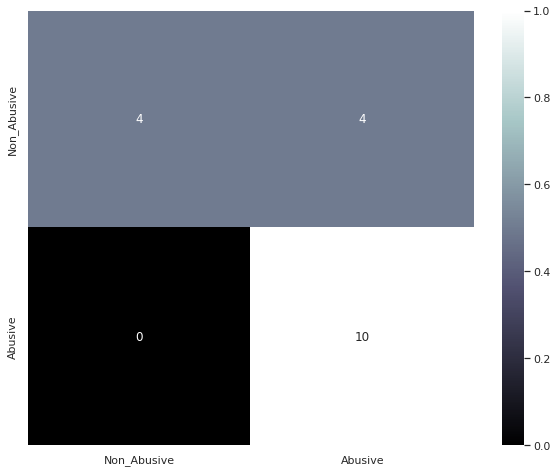

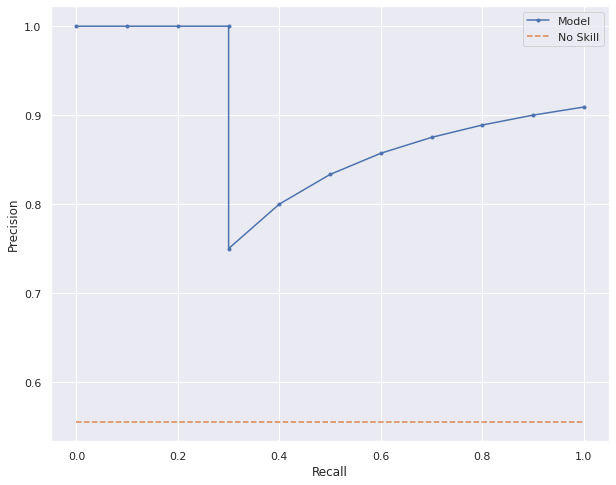




ROC AUC=0.912 



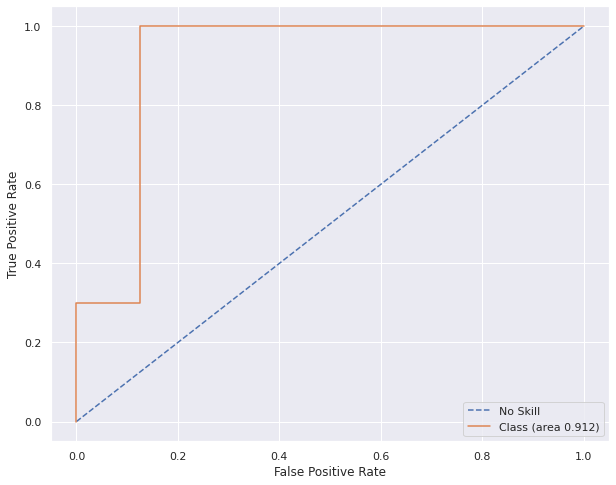



Cohen's kappa: 52.63%




In [48]:
print("\nMultinomial Naive Bayes for TF-IDF\n")
metrics_ML(naive_bayes.MultinomialNB(),  xtrain_tfidf, train_y, xvalid_tfidf, valid_y, LBL, gb=True)

Multinomial Naive Bayes for TF-IDF N-Grams


Multinomial Naive Bayes for TF-IDF n-grams

Execution time : 0.002 s
Score : 88.89 %

Classification Report

              precision    recall  f1-score   support

 Non_Abusive       1.00      0.75      0.86         8
     Abusive       0.83      1.00      0.91        10

    accuracy                           0.89        18
   macro avg       0.92      0.88      0.88        18
weighted avg       0.91      0.89      0.89        18


Confusion Matrix





Model: f1-score=0.909 AUC=0.972




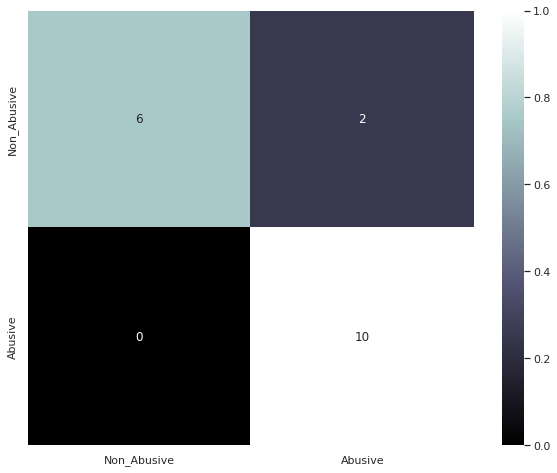

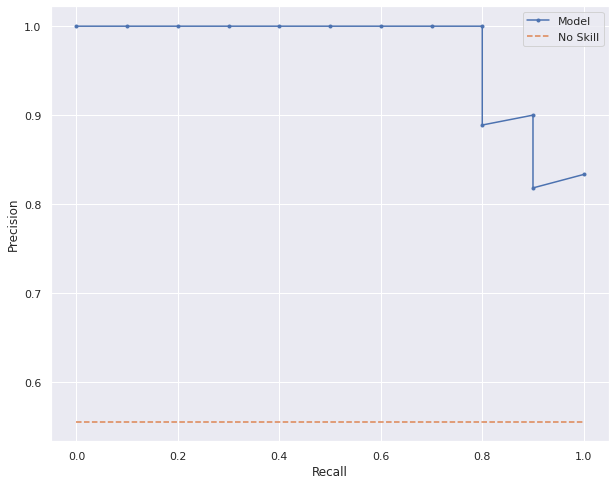




ROC AUC=0.963 



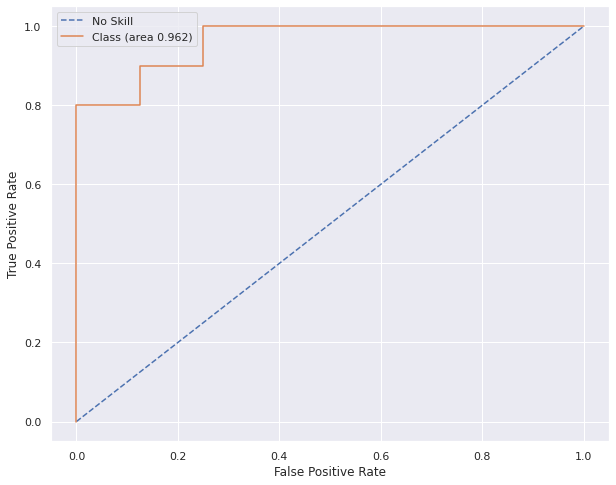



Cohen's kappa: 76.92%




In [49]:
print("\nMultinomial Naive Bayes for TF-IDF n-grams\n")
metrics_ML(naive_bayes.MultinomialNB(),  xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram, valid_y, LBL, gb=True)

Multinomial Naive Bayes for TF-IDF N-Grams Characterwise


Multinomial Naive Bayes for TF-IDF char n-grams

Execution time : 0.005 s
Score : 94.44 %

Classification Report

              precision    recall  f1-score   support

 Non_Abusive       1.00      0.88      0.93         8
     Abusive       0.91      1.00      0.95        10

    accuracy                           0.94        18
   macro avg       0.95      0.94      0.94        18
weighted avg       0.95      0.94      0.94        18


Confusion Matrix





Model: f1-score=0.952 AUC=0.955




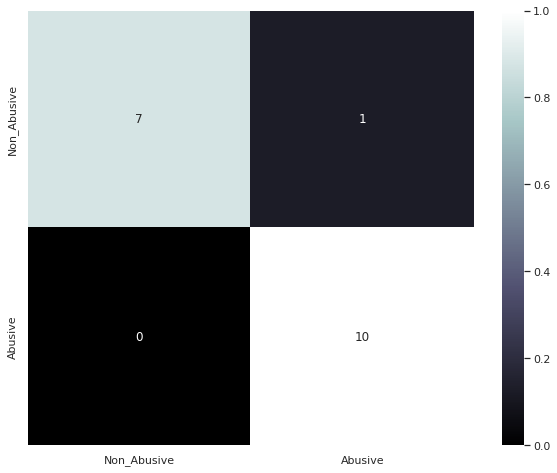

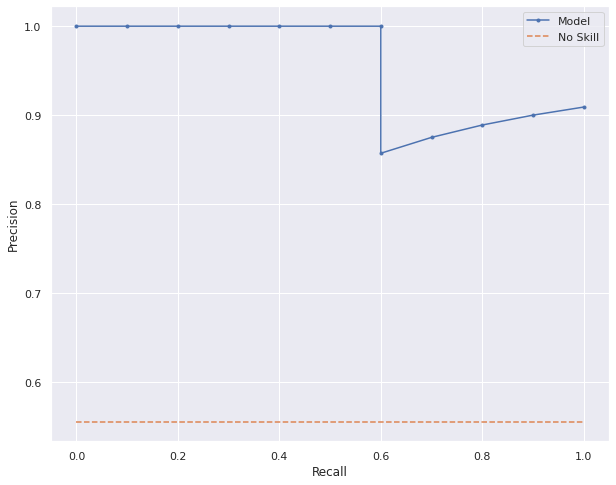




ROC AUC=0.950 



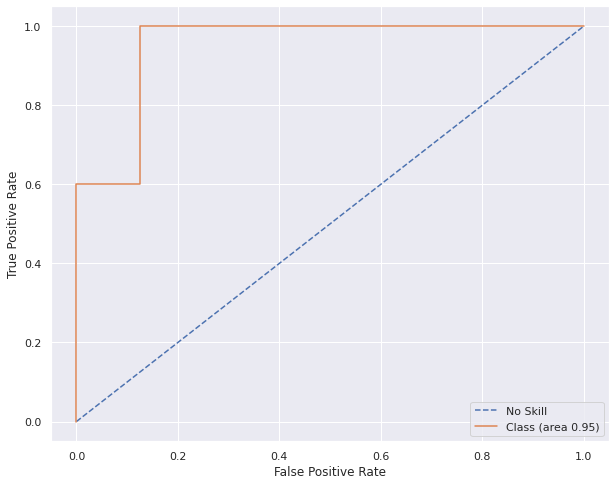



Cohen's kappa: 88.61%




In [50]:
print("\nMultinomial Naive Bayes for TF-IDF char n-grams\n")
metrics_ML(naive_bayes.MultinomialNB(),  xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars, valid_y, LBL, gb=True)

Logistic Regression for One-Hot Encoding


Logistic Regression for One-Hot encoding

Execution time : 0.096 s
Score : 94.44 %

Classification Report

              precision    recall  f1-score   support

 Non_Abusive       0.89      1.00      0.94         8
     Abusive       1.00      0.90      0.95        10

    accuracy                           0.94        18
   macro avg       0.94      0.95      0.94        18
weighted avg       0.95      0.94      0.94        18


Confusion Matrix





Model: f1-score=0.947 AUC=1.000




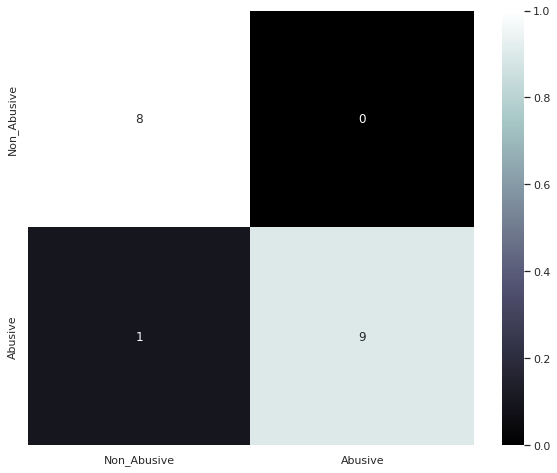

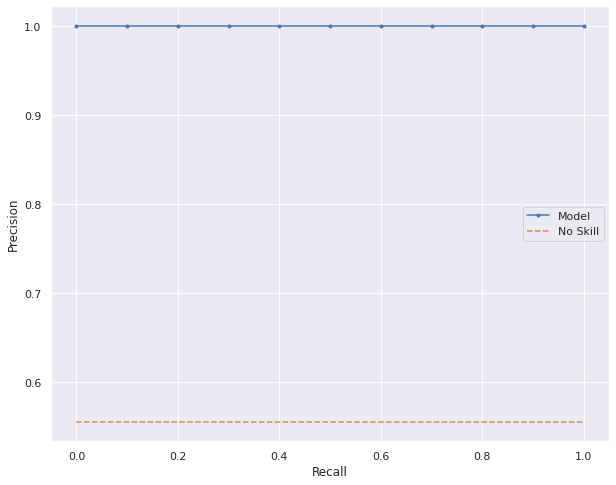




ROC AUC=1.000 



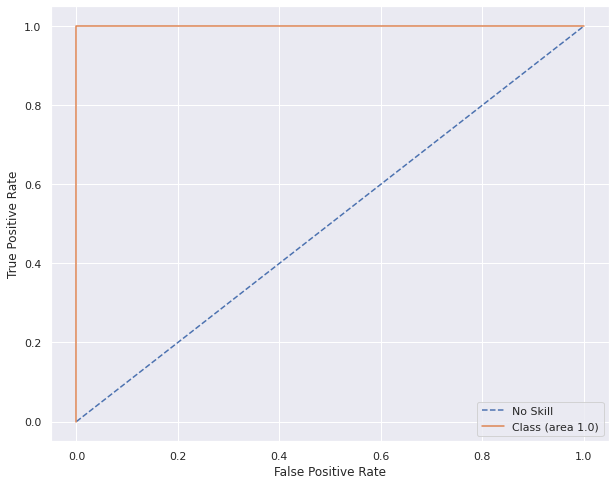



Cohen's kappa: 88.89%




In [51]:
print("\nLogistic Regression for One-Hot encoding\n")
metrics_ML(linear_model.LogisticRegression(max_iter=1000,  random_state=42),  xtrain_count, train_y_sw, xvalid_count, valid_y_sw, LBL, gb=True)

Logistic Regression for TF_IDF


Logistic Regression for TF_IDF

Execution time : 0.014 s
Score : 94.44 %

Classification Report

              precision    recall  f1-score   support

 Non_Abusive       1.00      0.88      0.93         8
     Abusive       0.91      1.00      0.95        10

    accuracy                           0.94        18
   macro avg       0.95      0.94      0.94        18
weighted avg       0.95      0.94      0.94        18


Confusion Matrix





Model: f1-score=0.952 AUC=1.000




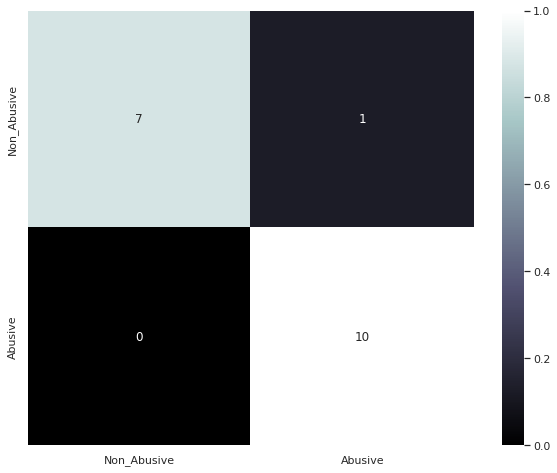

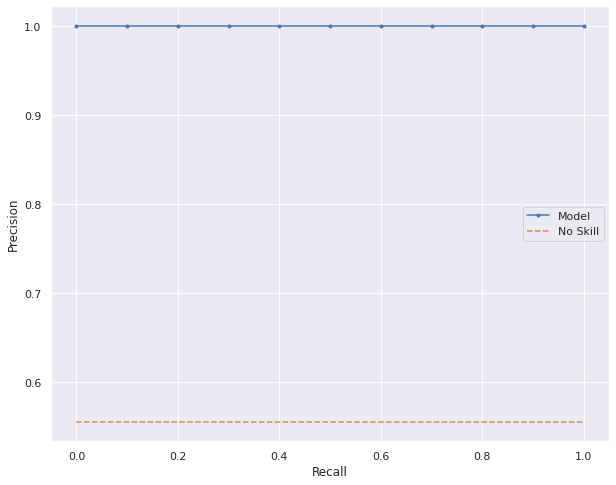




ROC AUC=1.000 



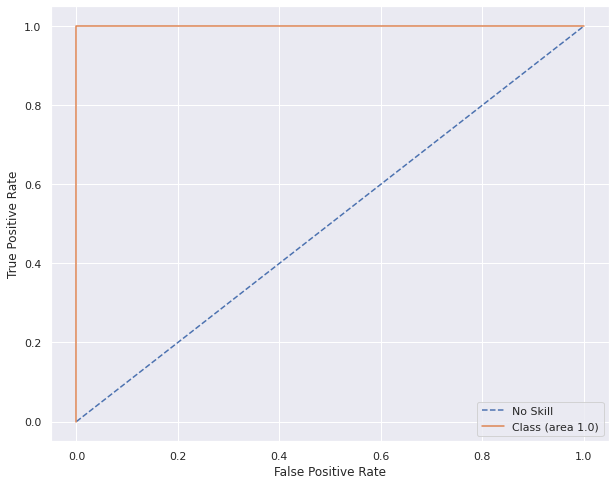



Cohen's kappa: 88.61%




In [52]:
print("\nLogistic Regression for TF_IDF\n")
metrics_ML(linear_model.LogisticRegression(max_iter=1000,  random_state=42),  xtrain_tfidf, train_y, xvalid_tfidf, valid_y, LBL, gb=True)

Logistic Regression for TF_IDF N-Grams 


Logistic Regression for TF_IDF n-grams

Execution time : 0.019 s
Score : 83.33 %

Classification Report

              precision    recall  f1-score   support

 Non_Abusive       1.00      0.62      0.77         8
     Abusive       0.77      1.00      0.87        10

    accuracy                           0.83        18
   macro avg       0.88      0.81      0.82        18
weighted avg       0.87      0.83      0.82        18


Confusion Matrix





Model: f1-score=0.870 AUC=0.990




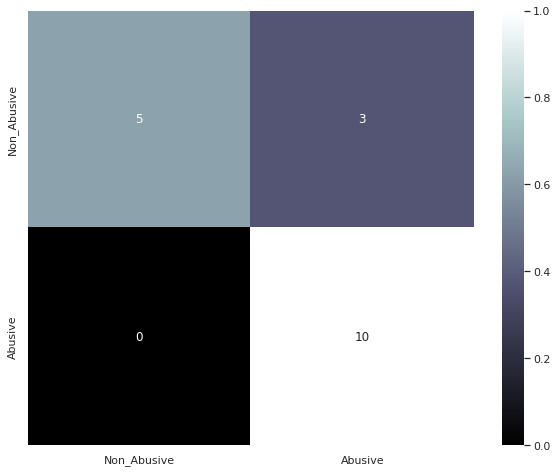

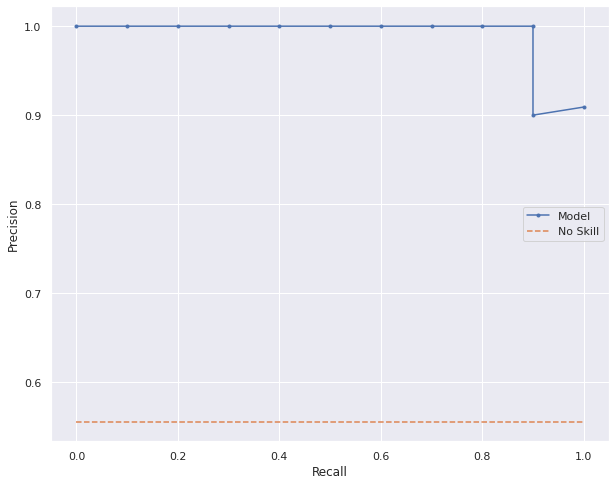




ROC AUC=0.988 



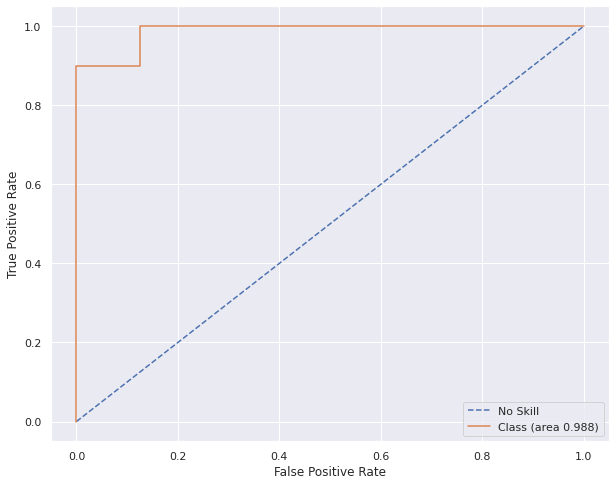



Cohen's kappa: 64.94%




In [53]:
print("\nLogistic Regression for TF_IDF n-grams\n")
metrics_ML(linear_model.LogisticRegression(max_iter=1000,  random_state=42),  xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram, valid_y, LBL, gb=True)

Logistic Regression for TF_IDF N-Grams Characterwise


Logistic Regression for TF_IDF char n-grams

Execution time : 0.023 s
Score : 94.44 %

Classification Report

              precision    recall  f1-score   support

 Non_Abusive       1.00      0.88      0.93         8
     Abusive       0.91      1.00      0.95        10

    accuracy                           0.94        18
   macro avg       0.95      0.94      0.94        18
weighted avg       0.95      0.94      0.94        18


Confusion Matrix





Model: f1-score=0.952 AUC=0.968




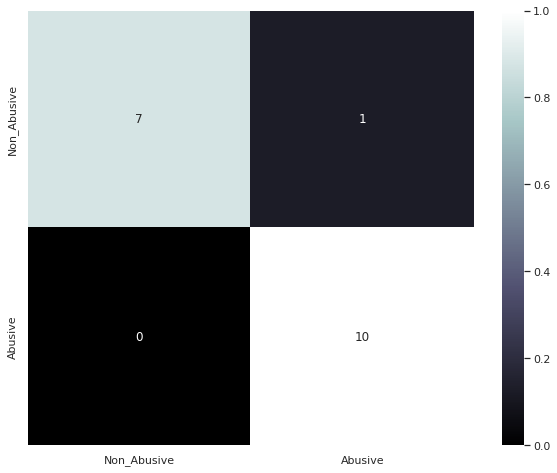

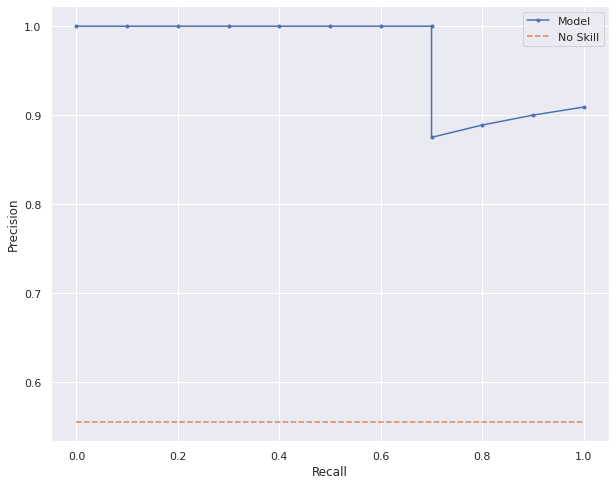




ROC AUC=0.963 



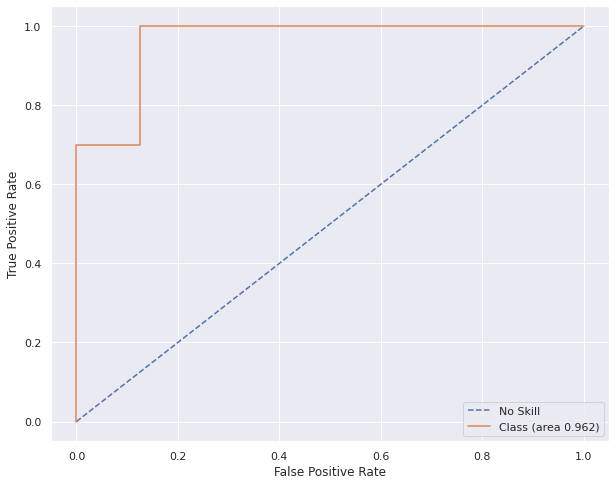



Cohen's kappa: 88.61%




In [54]:
print("\nLogistic Regression for TF_IDF char n-grams\n")
metrics_ML(linear_model.LogisticRegression(max_iter=1000,  random_state=42),  xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars, valid_y, LBL, gb = True)

SVM for One-Hot Encoding



SVM for One-Hot encoding

Execution time : 0.009 s
Score : 88.89 %

Classification Report

              precision    recall  f1-score   support

 Non_Abusive       1.00      0.75      0.86         8
     Abusive       0.83      1.00      0.91        10

    accuracy                           0.89        18
   macro avg       0.92      0.88      0.88        18
weighted avg       0.91      0.89      0.89        18


Confusion Matrix





Model: f1-score=0.909 AUC=0.917




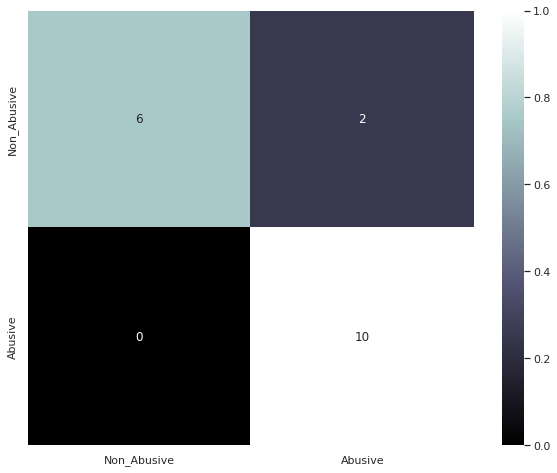

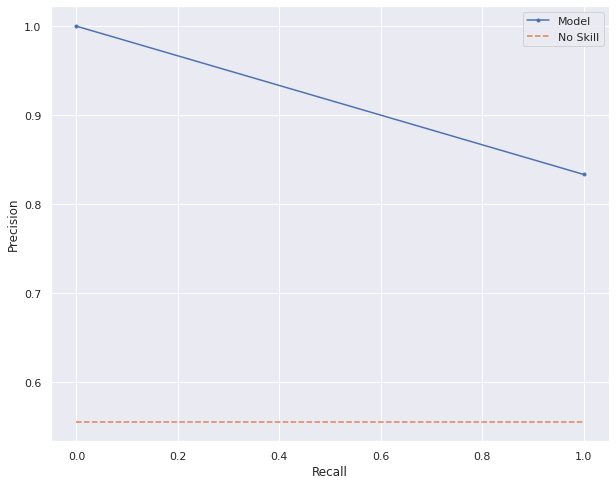




ROC AUC=0.875 



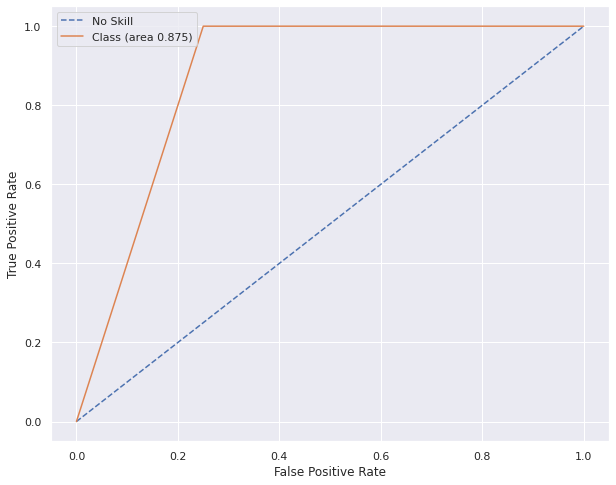



Cohen's kappa: 76.92%




In [55]:
print("\nSVM for One-Hot encoding\n")
metrics_ML(svm.SVC(),  xtrain_count, train_y, xvalid_count, valid_y, LBL, gb=False)

SVM for TF_IDF


SVM for TF_IDF

Execution time : 0.014 s
Score : 94.44 %

Classification Report

              precision    recall  f1-score   support

 Non_Abusive       1.00      0.88      0.93         8
     Abusive       0.91      1.00      0.95        10

    accuracy                           0.94        18
   macro avg       0.95      0.94      0.94        18
weighted avg       0.95      0.94      0.94        18


Confusion Matrix





Model: f1-score=0.952 AUC=0.955




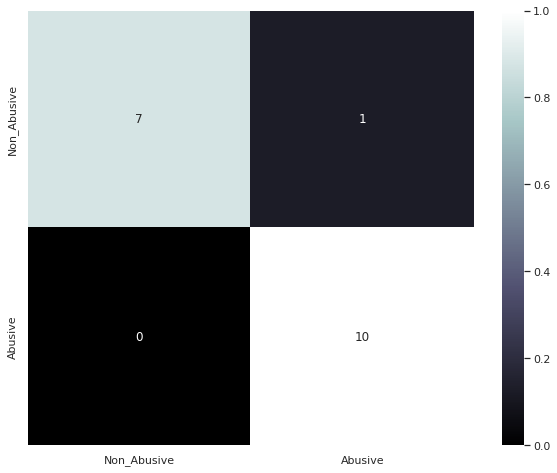

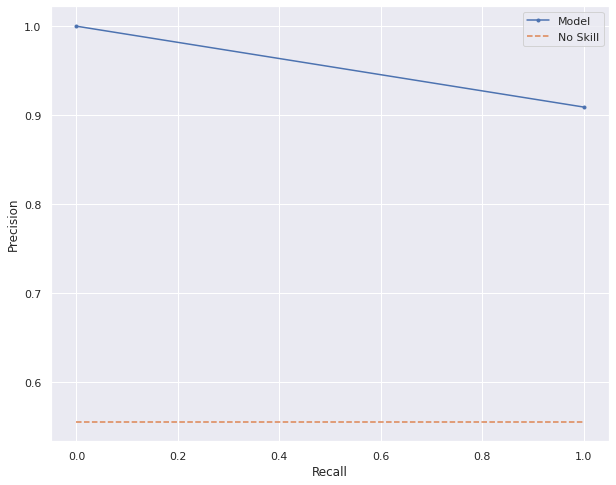




ROC AUC=0.938 



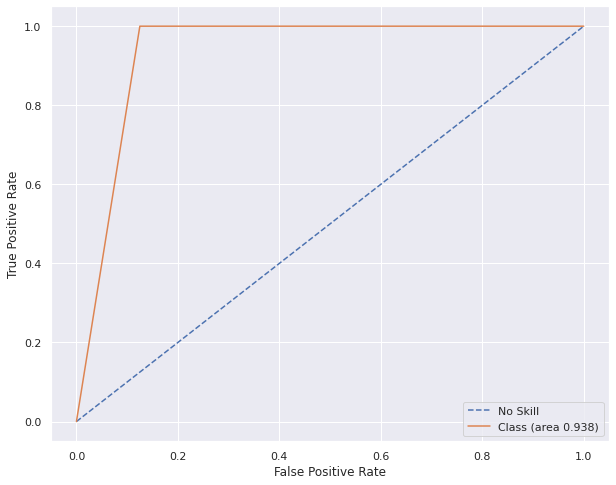



Cohen's kappa: 88.61%




In [56]:
print("\nSVM for TF_IDF\n")
metrics_ML(svm.SVC(),  xtrain_tfidf, train_y, xvalid_tfidf, valid_y, LBL, gb=False)

SVM for TF_IDF N-Grams 


SVM for TF_IDF n-grams

Execution time : 0.016 s
Score : 83.33 %

Classification Report

              precision    recall  f1-score   support

 Non_Abusive       1.00      0.62      0.77         8
     Abusive       0.77      1.00      0.87        10

    accuracy                           0.83        18
   macro avg       0.88      0.81      0.82        18
weighted avg       0.87      0.83      0.82        18


Confusion Matrix





Model: f1-score=0.870 AUC=0.885




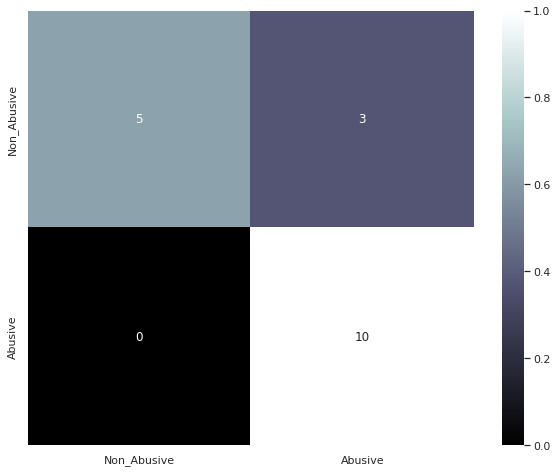

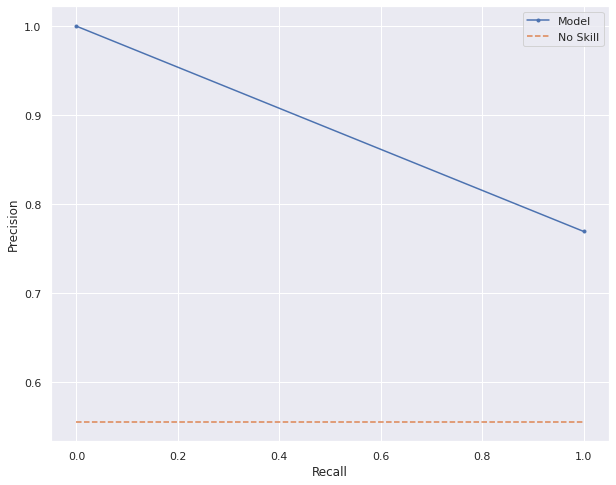




ROC AUC=0.812 



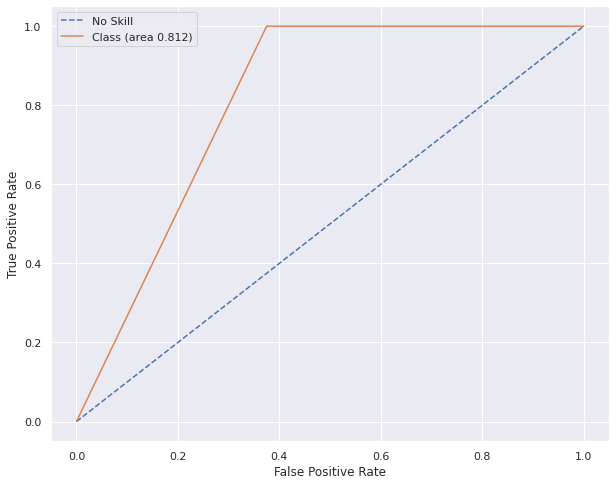



Cohen's kappa: 64.94%




In [57]:
print("\nSVM for TF_IDF n-grams\n")
metrics_ML(svm.SVC(),  xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram, valid_y, LBL, gb=False)

SVM for TF_IDF N-Grams Characterwise


SVM for TF_IDF char n-grams

Execution time : 0.038 s
Score : 94.44 %

Classification Report

              precision    recall  f1-score   support

 Non_Abusive       1.00      0.88      0.93         8
     Abusive       0.91      1.00      0.95        10

    accuracy                           0.94        18
   macro avg       0.95      0.94      0.94        18
weighted avg       0.95      0.94      0.94        18


Confusion Matrix





Model: f1-score=0.952 AUC=0.955




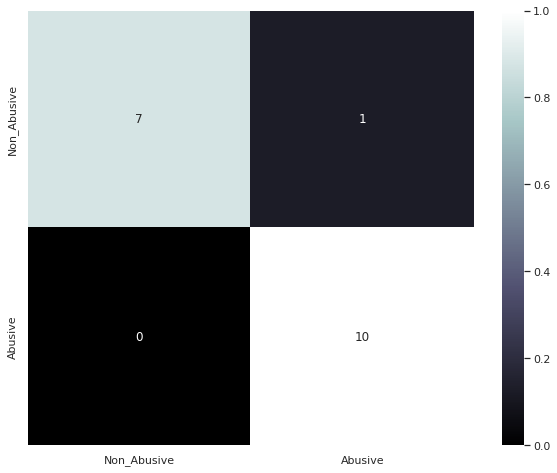

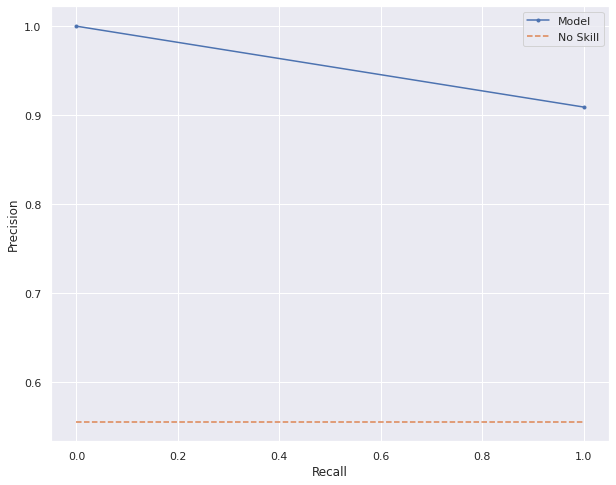




ROC AUC=0.938 



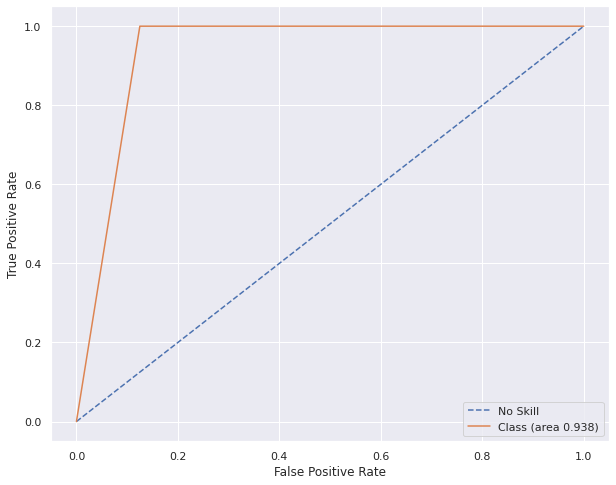



Cohen's kappa: 88.61%




In [58]:
print("\nSVM for TF_IDF char n-grams\n")
metrics_ML(svm.SVC(),  xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars, valid_y, LBL, gb=False)

KNN for One-Hot Encoding


k-NN for One-Hot encoding

Execution time : 0.001 s
Score : 94.44 %

Classification Report

              precision    recall  f1-score   support

 Non_Abusive       1.00      0.88      0.93         8
     Abusive       0.91      1.00      0.95        10

    accuracy                           0.94        18
   macro avg       0.95      0.94      0.94        18
weighted avg       0.95      0.94      0.94        18


Confusion Matrix





Model: f1-score=0.952 AUC=1.000




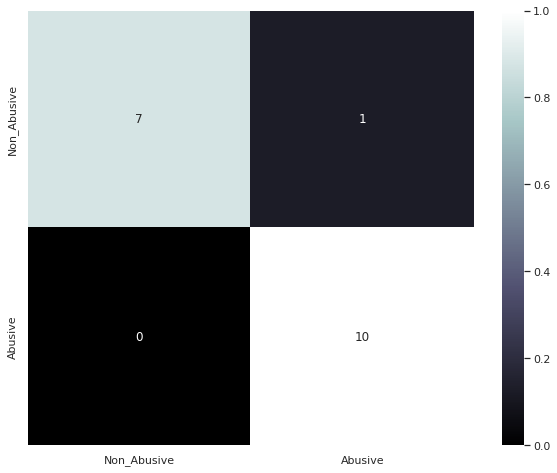

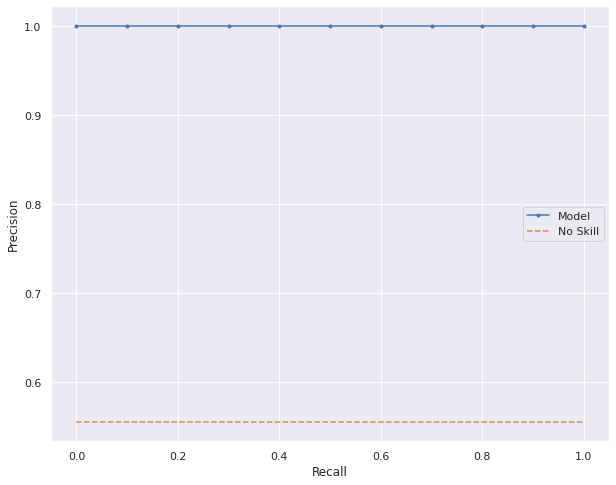




ROC AUC=1.000 



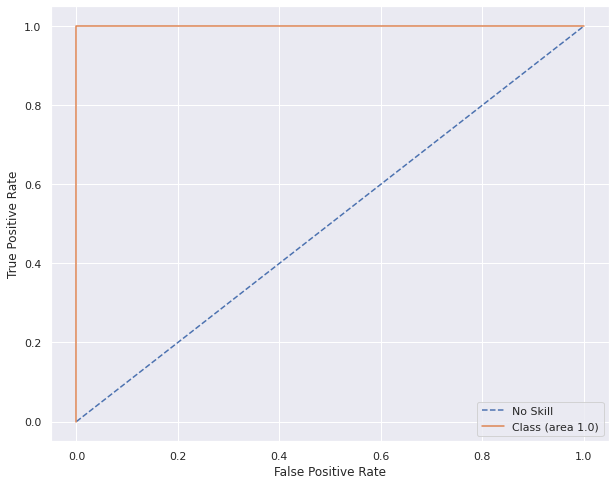



Cohen's kappa: 88.61%




In [59]:
print("\nk-NN for One-Hot encoding\n")
metrics_ML(neighbors.KNeighborsClassifier(n_neighbors=20, weights='distance', n_jobs=-1),  xtrain_count, train_y_sw, xvalid_count, valid_y_sw, LBL, gb=True)

KNN for TF_IDF


k-NN for TF_IDF

Execution time : 0.001 s
Score : 88.89 %

Classification Report

              precision    recall  f1-score   support

 Non_Abusive       0.88      0.88      0.88         8
     Abusive       0.90      0.90      0.90        10

    accuracy                           0.89        18
   macro avg       0.89      0.89      0.89        18
weighted avg       0.89      0.89      0.89        18


Confusion Matrix





Model: f1-score=0.900 AUC=0.990




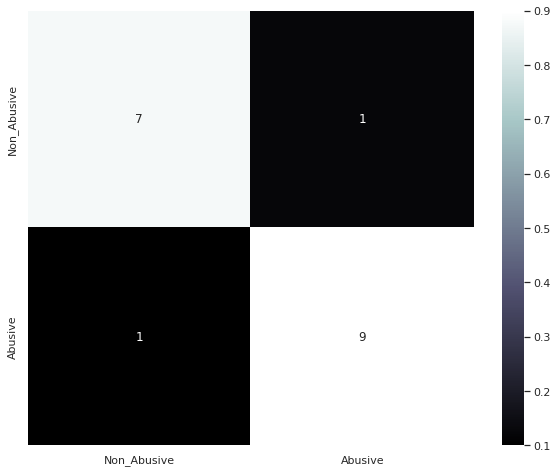

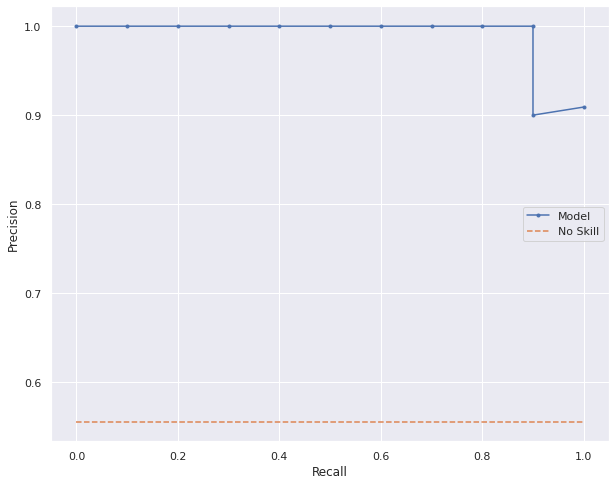




ROC AUC=0.988 



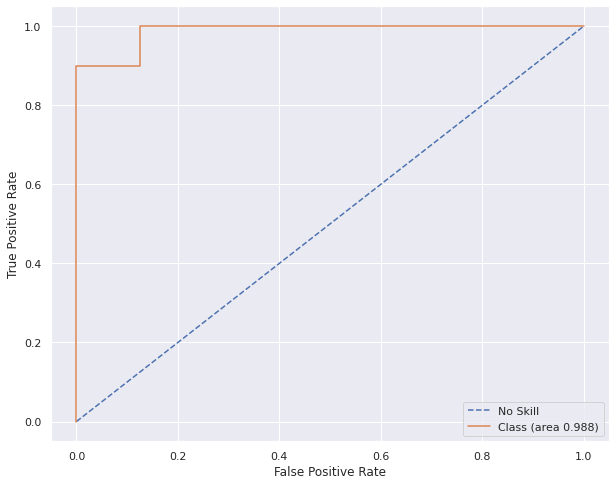



Cohen's kappa: 77.5%




In [60]:
print("\nk-NN for TF_IDF\n")
metrics_ML(neighbors.KNeighborsClassifier(n_neighbors=20, weights='distance', n_jobs=-1),  xtrain_tfidf, train_y, xvalid_tfidf, valid_y, LBL, gb=True)

KNN for TF_IDF N-Grams


k-NN for TF_IDF n-grams

Execution time : 0.001 s
Score : 88.89 %

Classification Report

              precision    recall  f1-score   support

 Non_Abusive       0.88      0.88      0.88         8
     Abusive       0.90      0.90      0.90        10

    accuracy                           0.89        18
   macro avg       0.89      0.89      0.89        18
weighted avg       0.89      0.89      0.89        18


Confusion Matrix





Model: f1-score=0.900 AUC=0.955




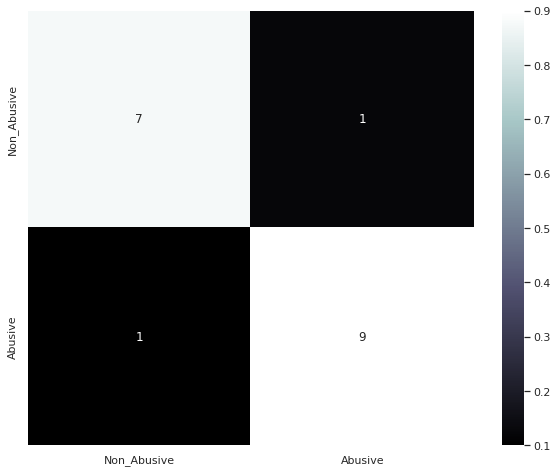

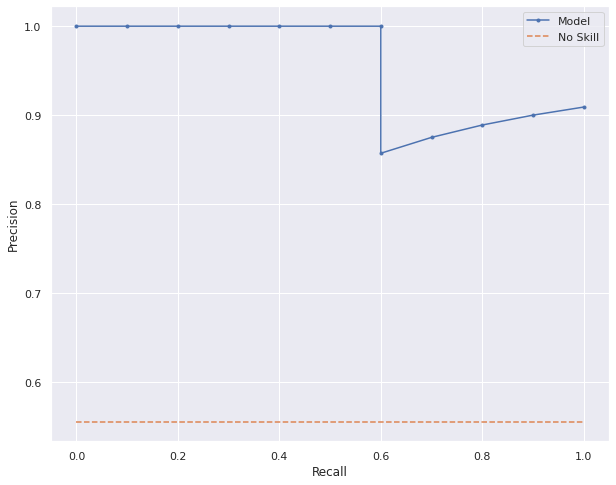




ROC AUC=0.950 



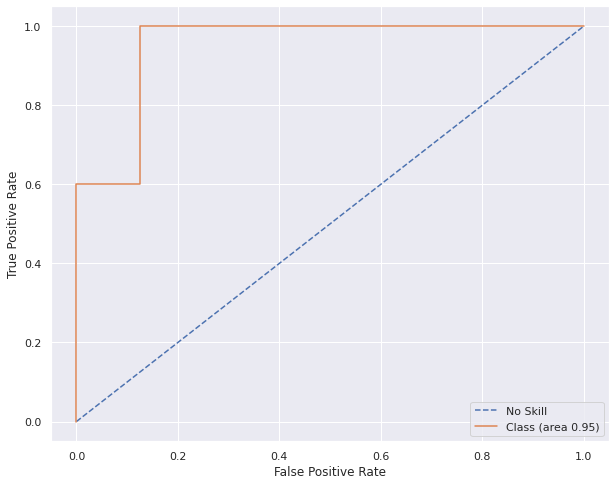



Cohen's kappa: 77.5%




In [61]:
print("\nk-NN for TF_IDF n-grams\n")
metrics_ML(neighbors.KNeighborsClassifier(n_neighbors=20, weights='distance', n_jobs=-1),  xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram, valid_y, LBL, gb=True)

KNN for TF_IDF N-Grams Characterwise


k-NN for TF_IDF char n-grams

Execution time : 0.001 s
Score : 72.22 %

Classification Report

              precision    recall  f1-score   support

 Non_Abusive       0.64      0.88      0.74         8
     Abusive       0.86      0.60      0.71        10

    accuracy                           0.72        18
   macro avg       0.75      0.74      0.72        18
weighted avg       0.76      0.72      0.72        18


Confusion Matrix





Model: f1-score=0.706 AUC=0.939




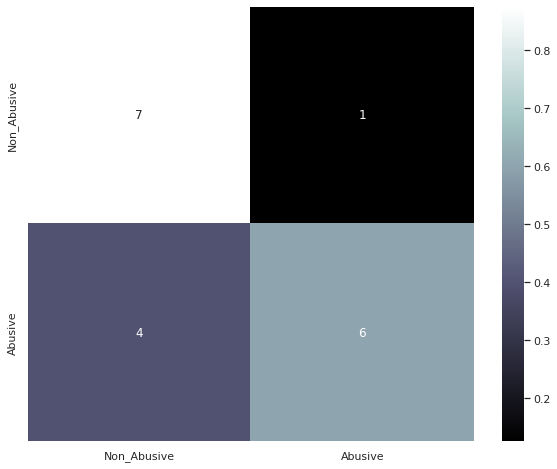

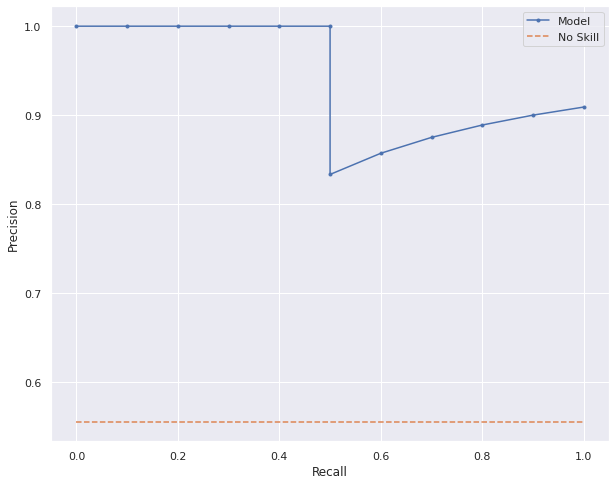




ROC AUC=0.938 



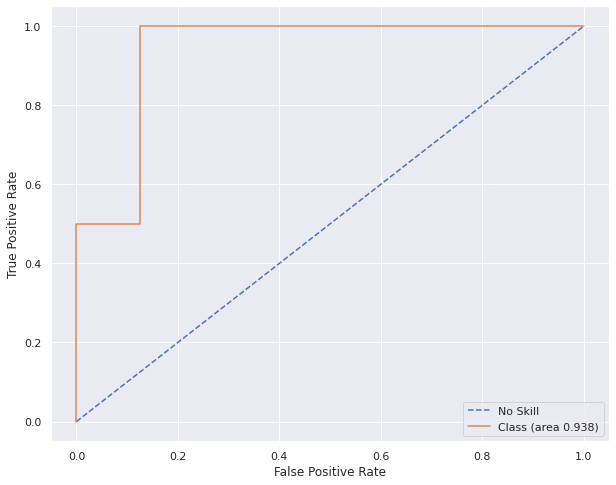



Cohen's kappa: 45.78%




In [62]:
print("\nk-NN for TF_IDF char n-grams\n")
metrics_ML(neighbors.KNeighborsClassifier(n_neighbors=20, weights='distance', n_jobs=-1),  
           xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars, valid_y, LBL, gb=True)

Random Forest for One-Hot Encoding


Random Forest for One-Hot encoding

Execution time : 0.296 s
Score : 94.44 %

Classification Report

              precision    recall  f1-score   support

 Non_Abusive       1.00      0.88      0.93         8
     Abusive       0.91      1.00      0.95        10

    accuracy                           0.94        18
   macro avg       0.95      0.94      0.94        18
weighted avg       0.95      0.94      0.94        18


Confusion Matrix





Model: f1-score=0.952 AUC=0.955




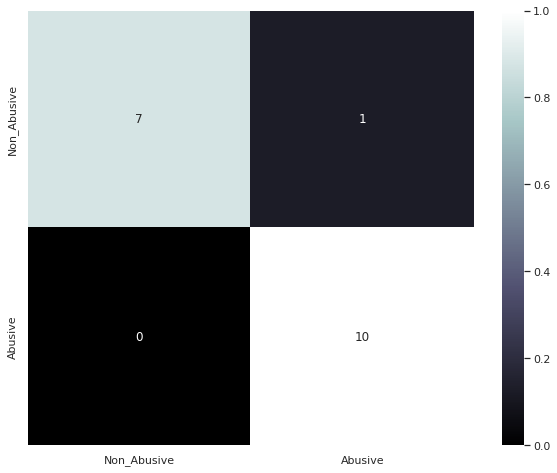

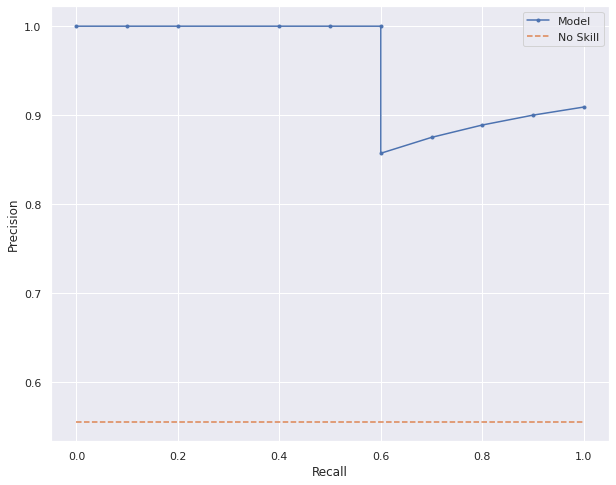




ROC AUC=0.950 



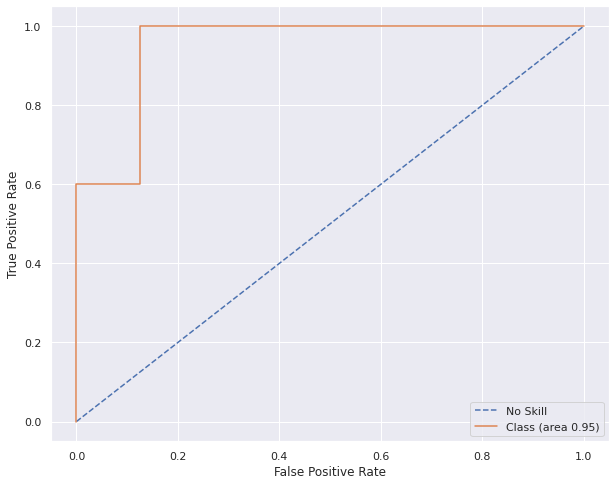



Cohen's kappa: 88.61%




In [63]:
print("\nRandom Forest for One-Hot encoding\n")
metrics_ML(ensemble.RandomForestClassifier(),  xtrain_count, train_y_sw, xvalid_count, valid_y_sw, LBL, gb=True)

Random Forest for TF_IDF


Random Forest for for TF-IDF

Execution time : 0.349 s
Score : 83.33 %

Classification Report

              precision    recall  f1-score   support

 Non_Abusive       0.86      0.75      0.80         8
     Abusive       0.82      0.90      0.86        10

    accuracy                           0.83        18
   macro avg       0.84      0.82      0.83        18
weighted avg       0.84      0.83      0.83        18


Confusion Matrix





Model: f1-score=0.857 AUC=0.916




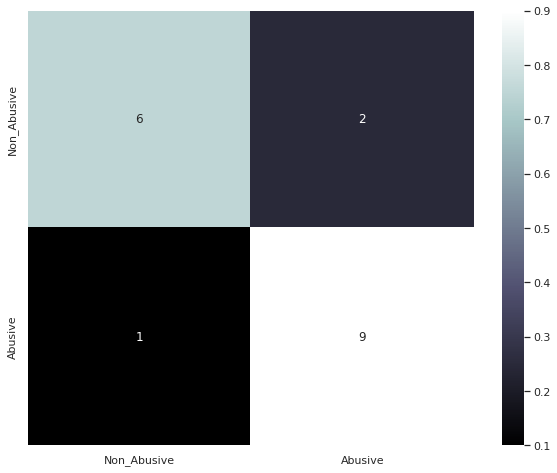

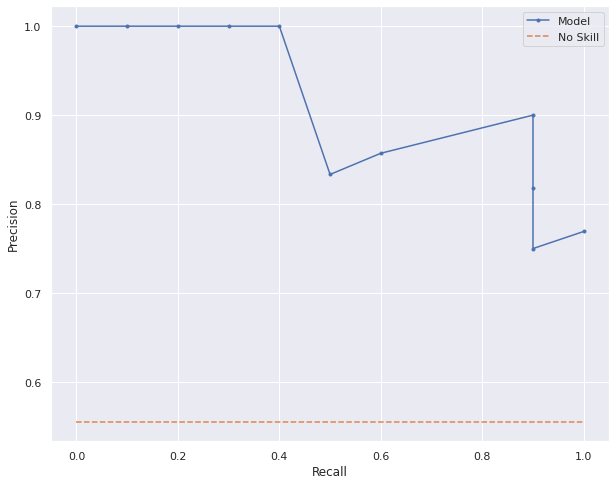




ROC AUC=0.906 



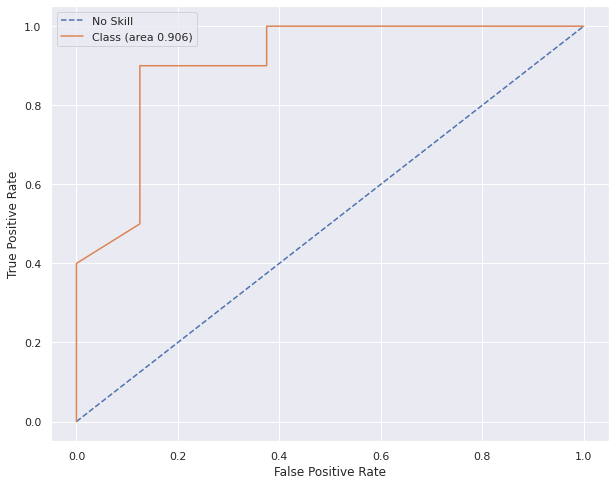



Cohen's kappa: 65.82%




In [64]:
print("\nRandom Forest for for TF-IDF\n")
metrics_ML(ensemble.RandomForestClassifier(),  xtrain_tfidf, train_y, xvalid_tfidf, valid_y, LBL, gb=True)

Random Forest for TF_IDF N Grams


Random Forest for TF_IDF n-grams

Execution time : 0.321 s
Score : 88.89 %

Classification Report

              precision    recall  f1-score   support

 Non_Abusive       1.00      0.75      0.86         8
     Abusive       0.83      1.00      0.91        10

    accuracy                           0.89        18
   macro avg       0.92      0.88      0.88        18
weighted avg       0.91      0.89      0.89        18


Confusion Matrix





Model: f1-score=0.909 AUC=0.983




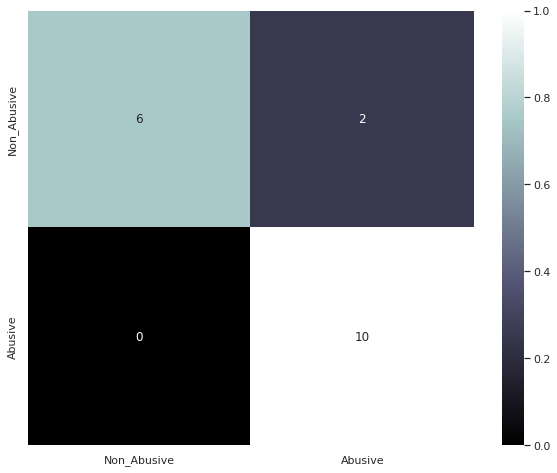

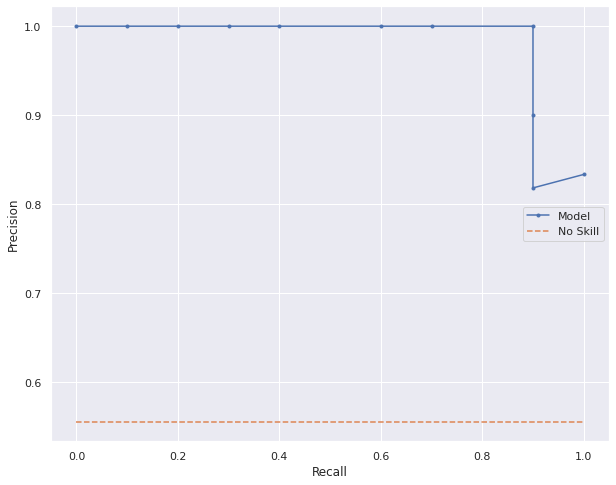




ROC AUC=0.975 



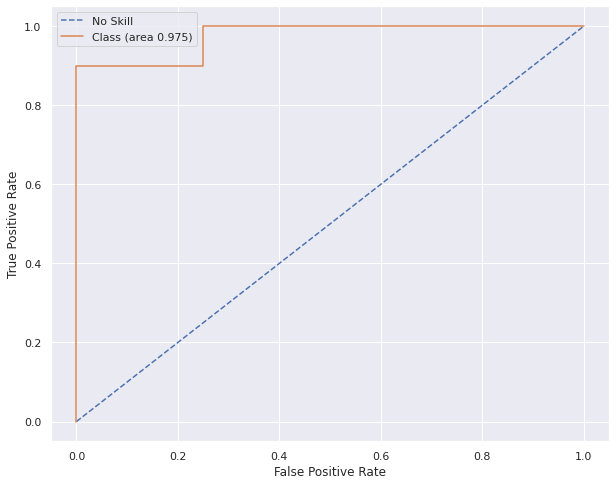



Cohen's kappa: 76.92%




In [65]:
print("\nRandom Forest for TF_IDF n-grams\n")
metrics_ML(ensemble.RandomForestClassifier(),  xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram, valid_y, LBL, gb=True)

Random Forest for TF_IDF N Grams Characterwise


Random Forest for TF_IDF char n-grams

Execution time : 0.539 s
Score : 88.89 %

Classification Report

              precision    recall  f1-score   support

 Non_Abusive       0.88      0.88      0.88         8
     Abusive       0.90      0.90      0.90        10

    accuracy                           0.89        18
   macro avg       0.89      0.89      0.89        18
weighted avg       0.89      0.89      0.89        18


Confusion Matrix





Model: f1-score=0.900 AUC=0.962




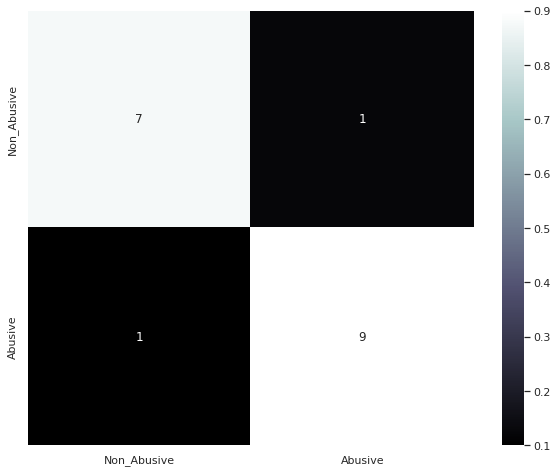

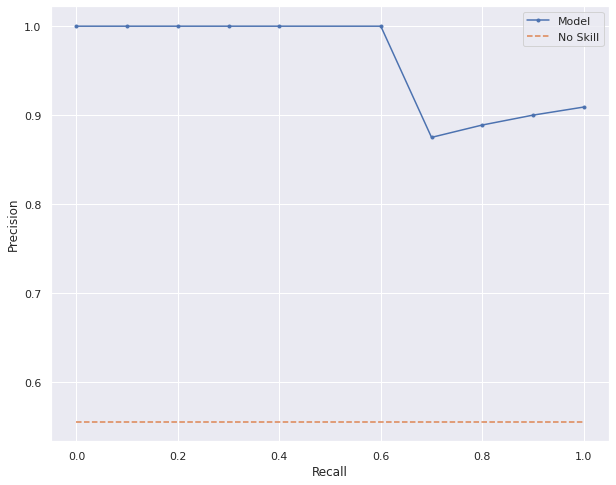




ROC AUC=0.956 



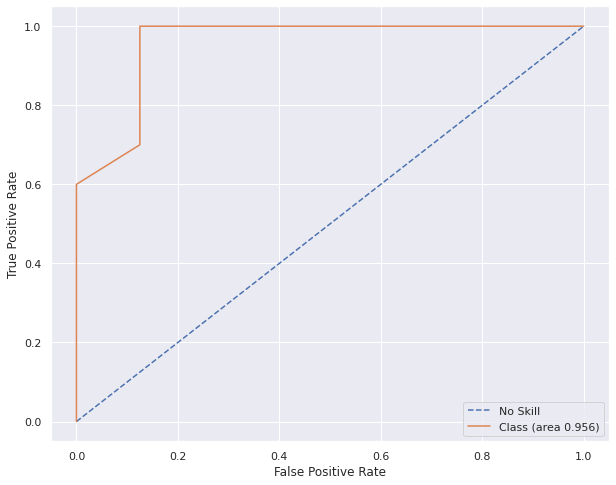



Cohen's kappa: 77.5%




In [66]:
print("\nRandom Forest for TF_IDF char n-grams\n")
metrics_ML(ensemble.RandomForestClassifier(),  xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars, valid_y, LBL, gb=True)

Stochastic Gradient Descent for One-Hot Encoding


Stochastic Gradient Descent with early stopping for One-Hot encoding

Early Stopping : 10 iterations without change
Execution time : 0.028 s
Score : 88.89 %

Classification Report

              precision    recall  f1-score   support

 Non_Abusive       0.80      1.00      0.89         8
     Abusive       1.00      0.80      0.89        10

    accuracy                           0.89        18
   macro avg       0.90      0.90      0.89        18
weighted avg       0.91      0.89      0.89        18


Confusion Matrix





Model: f1-score=0.889 AUC=0.956




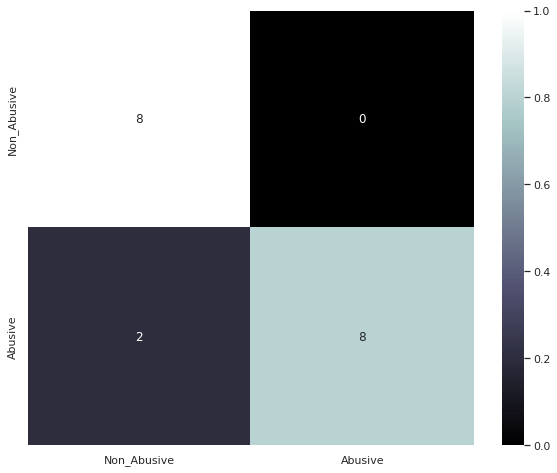

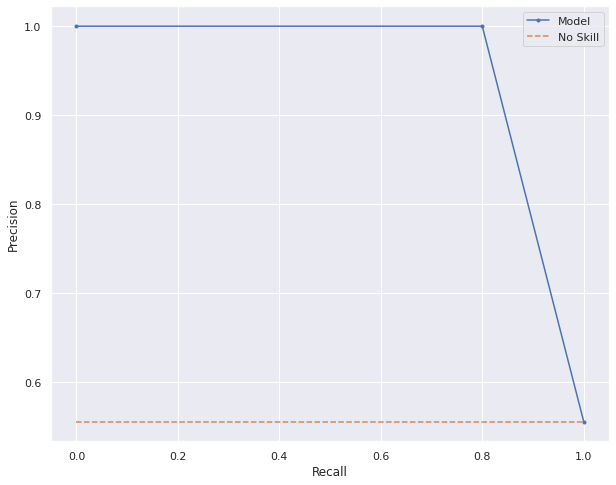




ROC AUC=0.900 



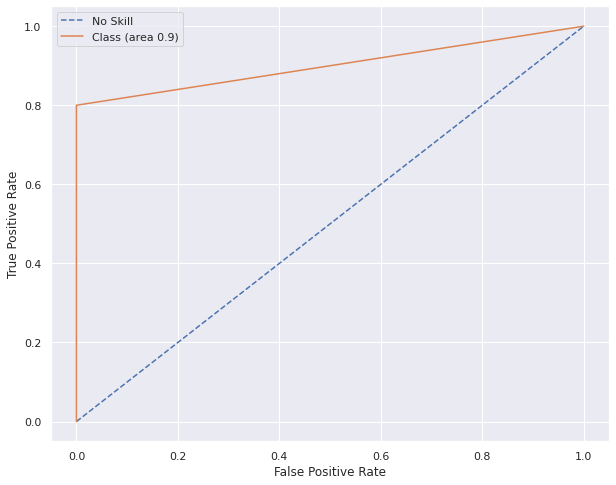



Cohen's kappa: 78.05%




In [67]:
print("\nStochastic Gradient Descent with early stopping for One-Hot encoding\n")
print("Early Stopping : 10 iterations without change")
metrics_ML(SGDClassifier(loss='modified_huber', max_iter=1000, tol=1e-3,   n_iter_no_change=10, early_stopping=True, n_jobs=-1 ), 
           xtrain_count, train_y_sw, xvalid_count, valid_y_sw, LBL, gb=True)

Stochastic Gradient Descent for TF_IDF


Stochastic Gradient Descent with early stopping for TF-IDF

Early Stopping : 10 iterations without change
Execution time : 0.015 s
Score : 94.44 %

Classification Report

              precision    recall  f1-score   support

 Non_Abusive       1.00      0.88      0.93         8
     Abusive       0.91      1.00      0.95        10

    accuracy                           0.94        18
   macro avg       0.95      0.94      0.94        18
weighted avg       0.95      0.94      0.94        18


Confusion Matrix





Model: f1-score=0.952 AUC=0.955




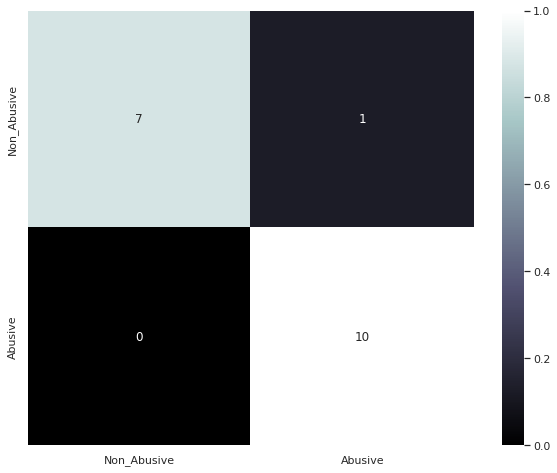

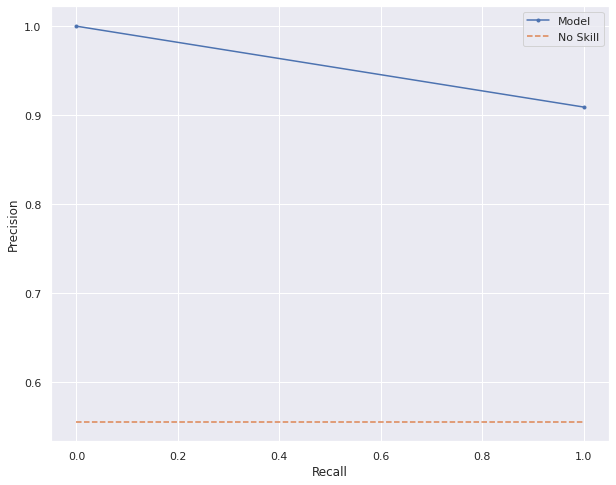




ROC AUC=0.938 



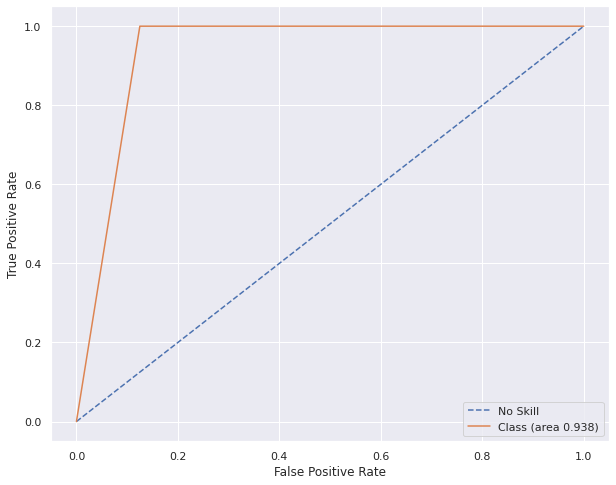



Cohen's kappa: 88.61%




In [68]:
print("\nStochastic Gradient Descent with early stopping for TF-IDF\n")
print("Early Stopping : 10 iterations without change")
metrics_ML(SGDClassifier(loss='modified_huber', max_iter=1000, tol=1e-3,   n_iter_no_change=10, early_stopping=True, n_jobs=-1 ),
           xtrain_tfidf, train_y, xvalid_tfidf, valid_y, LBL, gb=True)

Stochastic Gradient Descent for TF_IDF N Grams 


Stochastic Gradient Descent with early stopping for TF-IDF N-gram

Early Stopping : 10 iterations without change
Execution time : 0.023 s
Score : 83.33 %

Classification Report

              precision    recall  f1-score   support

 Non_Abusive       1.00      0.62      0.77         8
     Abusive       0.77      1.00      0.87        10

    accuracy                           0.83        18
   macro avg       0.88      0.81      0.82        18
weighted avg       0.87      0.83      0.82        18


Confusion Matrix





Model: f1-score=0.870 AUC=0.938




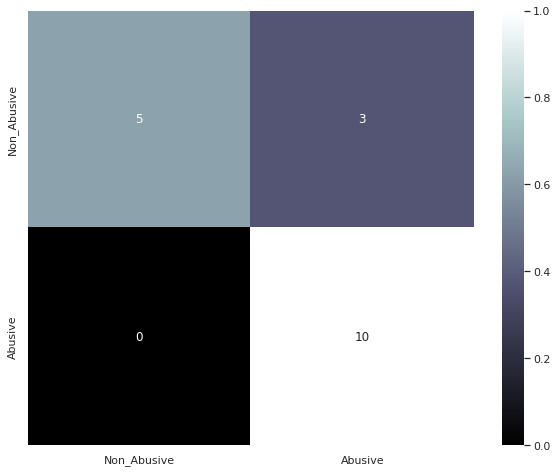

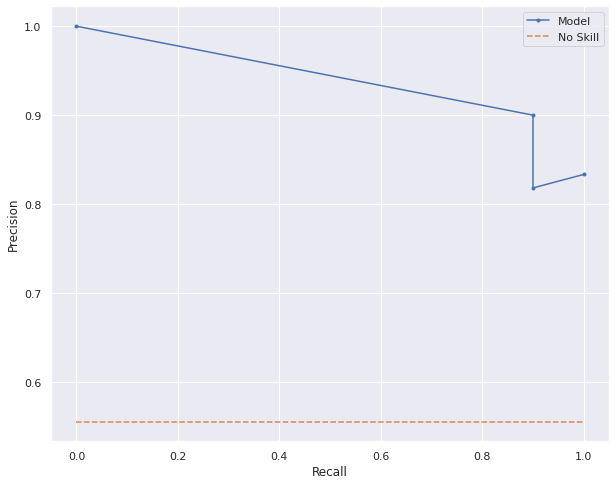




ROC AUC=0.919 



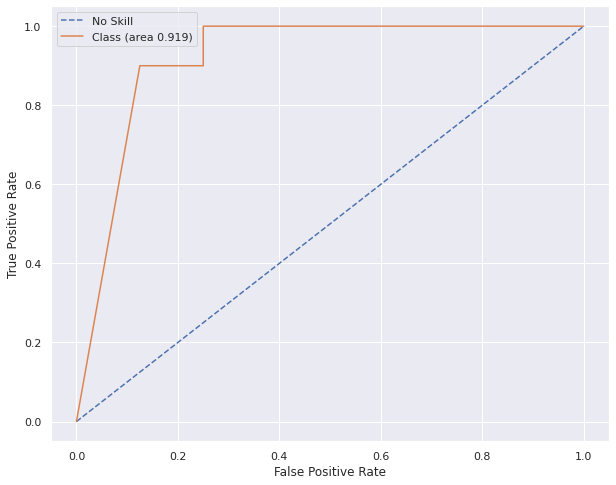



Cohen's kappa: 64.94%




In [69]:
print("\nStochastic Gradient Descent with early stopping for TF-IDF N-gram\n")
print("Early Stopping : 10 iterations without change")
metrics_ML(SGDClassifier(loss='modified_huber', max_iter=1000, tol=1e-3,   n_iter_no_change=10, early_stopping=True, n_jobs=-1 ),
           xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram, valid_y, LBL, gb=True)

Stochastic Gradient Descent for TF_IDF N Grams Characterwise


Stochastic Gradient Descent with early stopping for TF-IDF char n-gram

Early Stopping : 10 iterations without change
Execution time : 0.060 s
Score : 83.33 %

Classification Report

              precision    recall  f1-score   support

 Non_Abusive       0.78      0.88      0.82         8
     Abusive       0.89      0.80      0.84        10

    accuracy                           0.83        18
   macro avg       0.83      0.84      0.83        18
weighted avg       0.84      0.83      0.83        18


Confusion Matrix





Model: f1-score=0.842 AUC=0.944




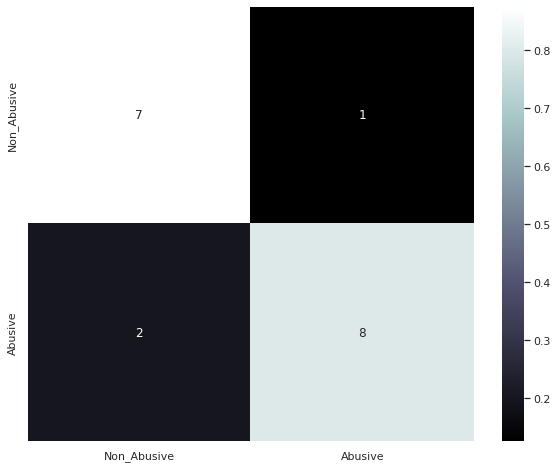

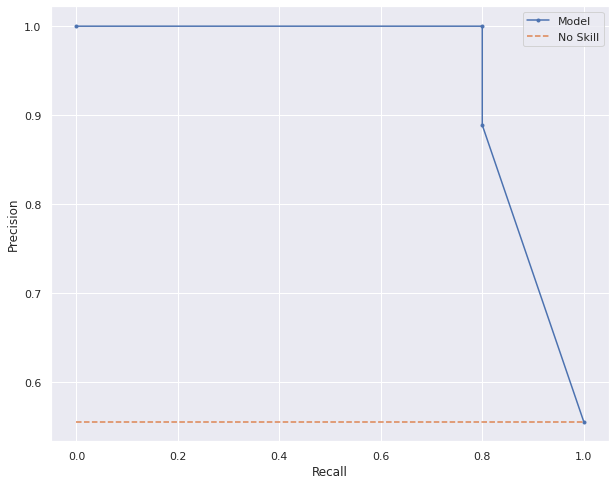




ROC AUC=0.887 



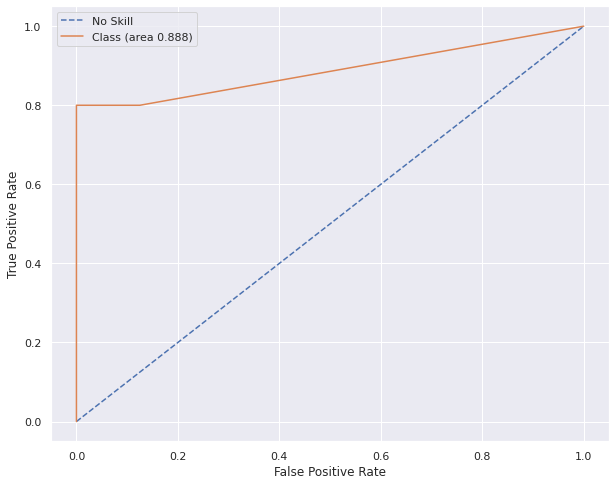



Cohen's kappa: 66.67%




In [70]:
print("\nStochastic Gradient Descent with early stopping for TF-IDF char n-gram\n")
print("Early Stopping : 10 iterations without change")
metrics_ML(SGDClassifier(loss='modified_huber', max_iter=1000, tol=1e-3,   n_iter_no_change=10, early_stopping=True, n_jobs=-1 ),
           xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars, valid_y, LBL, gb=True)

Gradient Boosting for Count Vectorizer


Gradient Boosting with early stopping for Count Vectors

Early Stopping : 5 iterations without change
Execution time : 0.063 s
Score : 77.78 %

Classification Report

              precision    recall  f1-score   support

 Non_Abusive       0.75      0.75      0.75         8
     Abusive       0.80      0.80      0.80        10

    accuracy                           0.78        18
   macro avg       0.78      0.78      0.78        18
weighted avg       0.78      0.78      0.78        18


Confusion Matrix





Model: f1-score=0.800 AUC=0.914




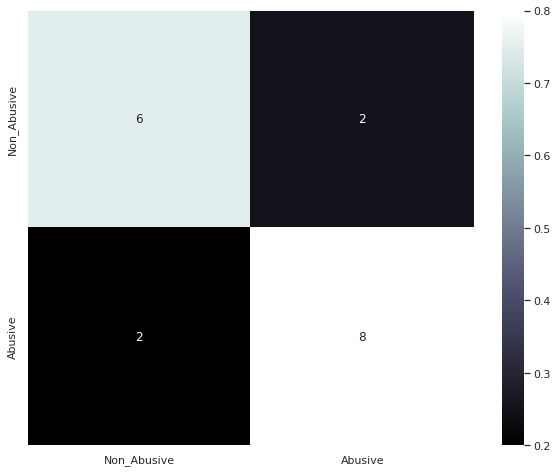

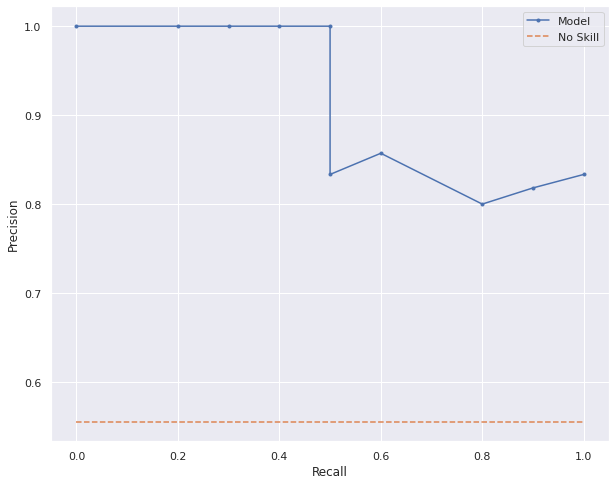




ROC AUC=0.900 



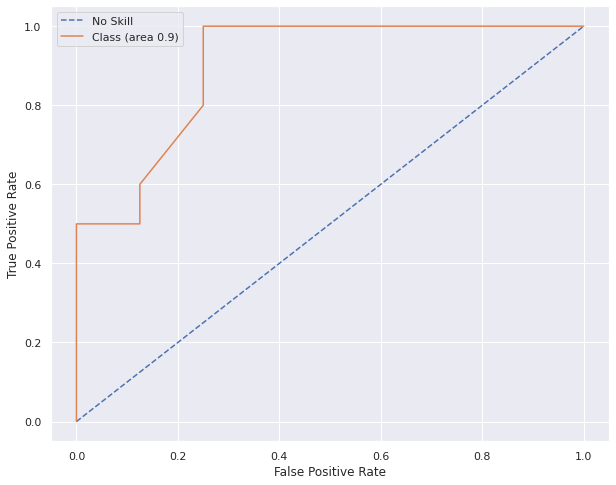



Cohen's kappa: 55.0%




In [71]:
print("\nGradient Boosting with early stopping for Count Vectors\n")
print("Early Stopping : 5 iterations without change")
metrics_ML(ensemble.GradientBoostingClassifier(n_estimators=1000,
                                               validation_fraction=0.2,
                                               n_iter_no_change=5, tol=0.01,
                                               random_state=0, verbose=0), xtrain_count, train_y_sw, xvalid_count, valid_y_sw, LBL, gb=True)

Gradient Boosting for TF_IDF


Gradient Boosting with early stopping for TF-IDF

Early Stopping : 5 iterations without change
Execution time : 0.113 s
Score : 94.44 %

Classification Report

              precision    recall  f1-score   support

 Non_Abusive       0.89      1.00      0.94         8
     Abusive       1.00      0.90      0.95        10

    accuracy                           0.94        18
   macro avg       0.94      0.95      0.94        18
weighted avg       0.95      0.94      0.94        18


Confusion Matrix





Model: f1-score=0.947 AUC=1.000




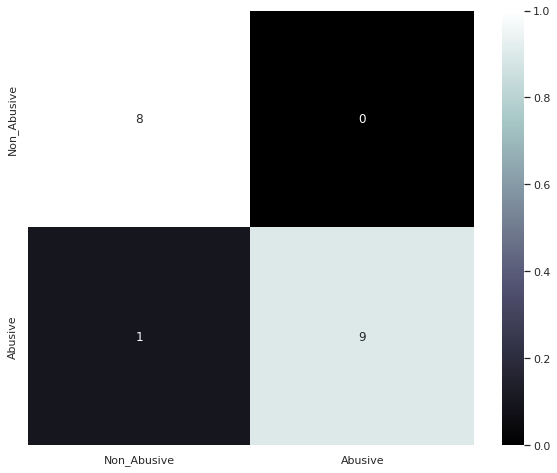

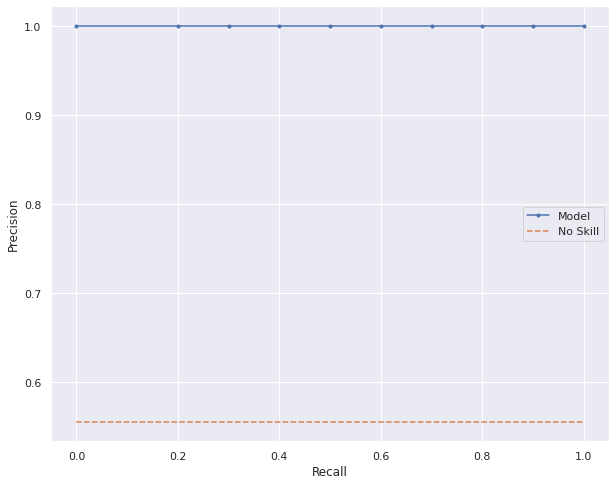




ROC AUC=1.000 



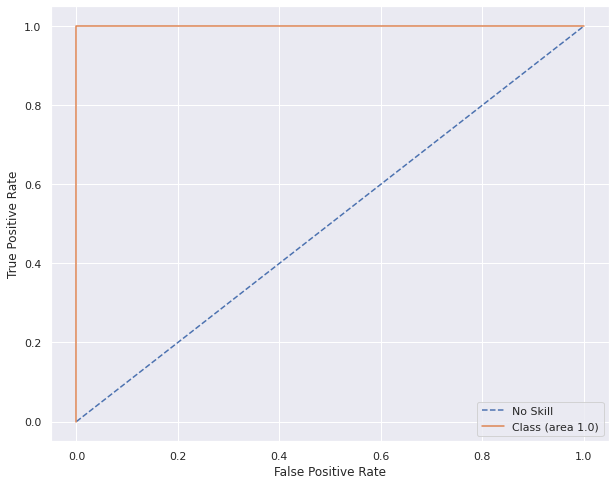



Cohen's kappa: 88.89%




In [72]:
print("\nGradient Boosting with early stopping for TF-IDF\n")
print("Early Stopping : 5 iterations without change")
metrics_ML(ensemble.GradientBoostingClassifier(n_estimators=1000,
                                               validation_fraction=0.2,
                                               n_iter_no_change=5, tol=0.01,
                                               random_state=0, verbose=0), xtrain_tfidf, train_y, xvalid_tfidf, valid_y, LBL, gb=True)

Gradient Boosting for TF_IDF N Grams


Gradient Boosting with early stopping for TF_IDF ngram

Early Stopping : 5 iterations without change
Execution time : 0.065 s
Score : 72.22 %

Classification Report

              precision    recall  f1-score   support

 Non_Abusive       0.80      0.50      0.62         8
     Abusive       0.69      0.90      0.78        10

    accuracy                           0.72        18
   macro avg       0.75      0.70      0.70        18
weighted avg       0.74      0.72      0.71        18


Confusion Matrix





Model: f1-score=0.783 AUC=0.865




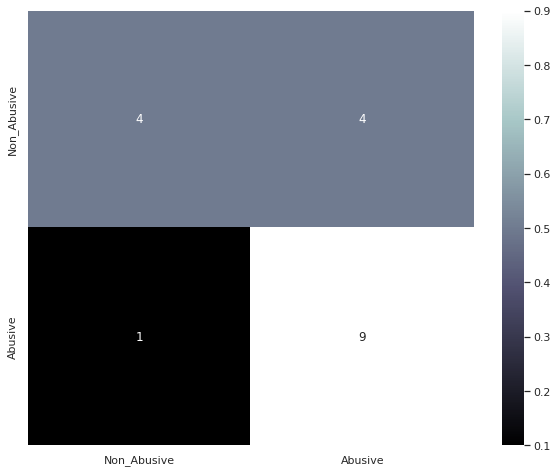

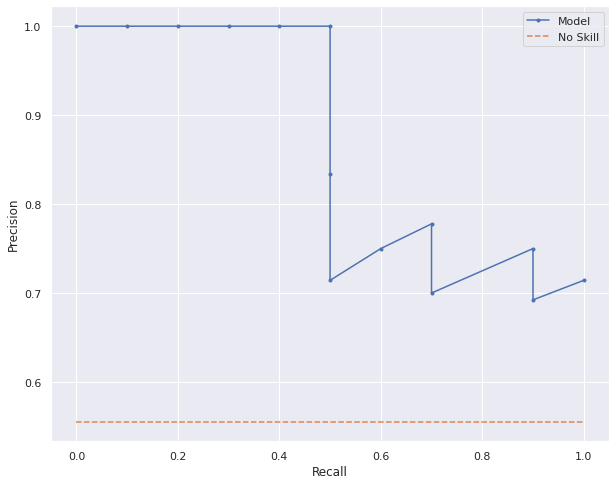




ROC AUC=0.825 



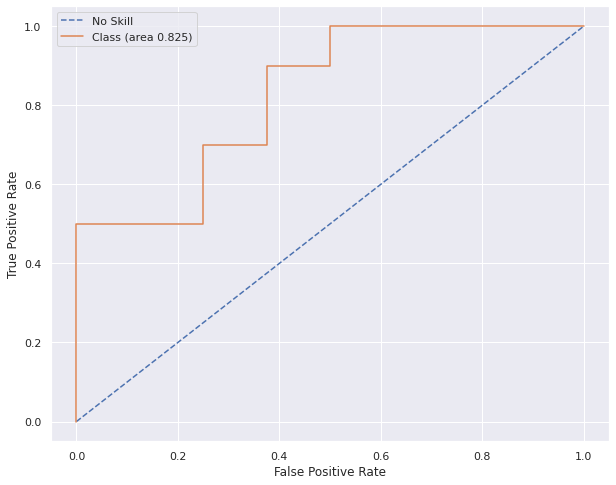



Cohen's kappa: 41.56%




In [73]:
print("\nGradient Boosting with early stopping for TF_IDF ngram\n")
print("Early Stopping : 5 iterations without change")
metrics_ML(ensemble.GradientBoostingClassifier(n_estimators=1000,
                                               validation_fraction=0.2,
                                               n_iter_no_change=5, tol=0.01,
                                               random_state=0, verbose=0),xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram, valid_y, LBL, gb=True)

Gradient Boosting for TF_IDF N Grams Characters


Gradient Boosting with early stopping for TF-IDF ngram chars

Early Stopping : 5 iterations without change
Execution time : 0.080 s
Score : 61.11 %

Classification Report

              precision    recall  f1-score   support

 Non_Abusive       0.54      0.88      0.67         8
     Abusive       0.80      0.40      0.53        10

    accuracy                           0.61        18
   macro avg       0.67      0.64      0.60        18
weighted avg       0.68      0.61      0.59        18


Confusion Matrix





Model: f1-score=0.533 AUC=0.718




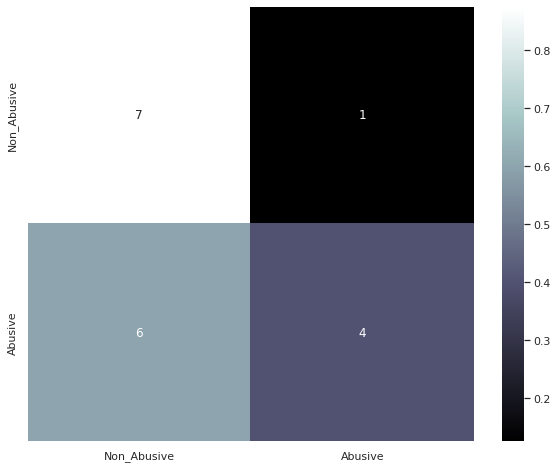

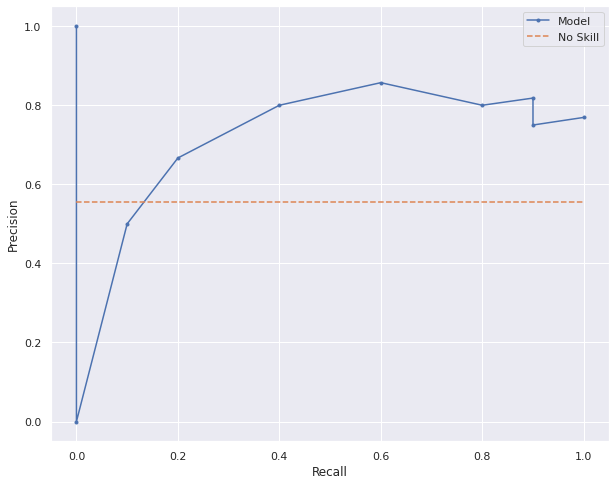




ROC AUC=0.825 



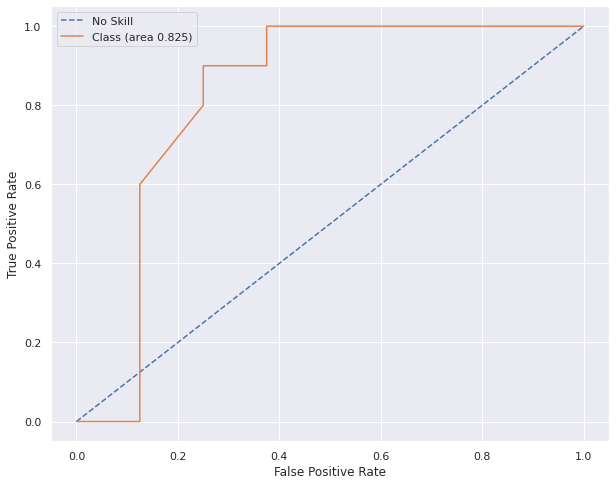



Cohen's kappa: 25.88%




In [74]:
print("\nGradient Boosting with early stopping for TF-IDF ngram chars\n")
print("Early Stopping : 5 iterations without change")
metrics_ML(ensemble.GradientBoostingClassifier(n_estimators=1000,
                                               validation_fraction=0.2,
                                               n_iter_no_change=5, tol=0.01,
                                               random_state=0, verbose=0),xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars, valid_y, LBL, gb=True)

XG Boost Model

In [75]:
def xgb_model(X_train, y_train, X_test, y_test, labels=labels):
    model = XGBClassifier(n_estimators=1000, subsample=0.8)
    eval_set = [(X_train, y_train), (X_test, y_test)]
    if len(labels)>2:
        model.fit(X_train, y_train, eval_metric=["merror", "mlogloss"],  eval_set=eval_set,early_stopping_rounds=10, verbose=False) #
    else:
        model.fit(X_train, y_train, eval_metric=["error", "logloss"],  eval_set=eval_set,early_stopping_rounds=10, verbose=False) #
    
    # make predictions for test data
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(valid_y, predictions)
    print("\nAccuracy: %.2f%%" % (accuracy * 100.0))
    return model, y_pred, accuracy

def rmsle_eval(y, y0):
    
    y0=y0.get_label()    
    assert len(y) == len(y0)
    return 'error',np.sqrt(np.mean(np.power(np.log1p(y)-np.log1p(y0), 2)))

XG Boost for Count Vectorizer


XGBoost for Count Vectors


Accuracy: 94.44%

Classification Report

              precision    recall  f1-score   support

 Non_Abusive       1.00      0.88      0.93         8
     Abusive       0.91      1.00      0.95        10

    accuracy                           0.94        18
   macro avg       0.95      0.94      0.94        18
weighted avg       0.95      0.94      0.94        18


Confusion Matrix



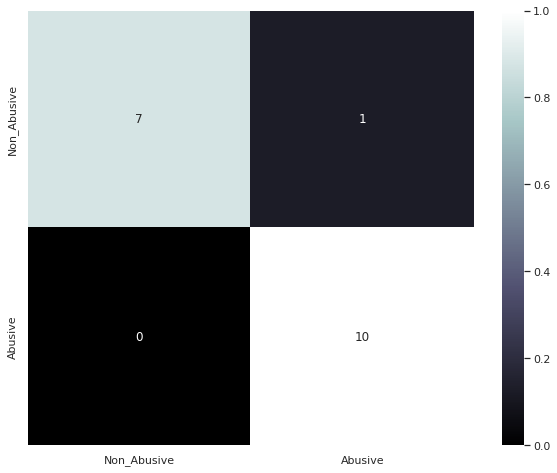

In [76]:
print("\nXGBoost for Count Vectors\n")
xgbs, pred, accuracy = xgb_model(xtrain_count, train_y_sw, xvalid_count, valid_y_sw, labels=LBL)
print("\nClassification Report\n")
print(classification_report(valid_y_sw, pred, target_names=LBL))
cm = confusion_matrix(valid_y_sw, pred)
print("\nConfusion Matrix\n")
Metric.plot_confusion_matrix(cm, LBL)


The precision of the model is 90.91%


Model: f1-score=0.952 AUC=1.000




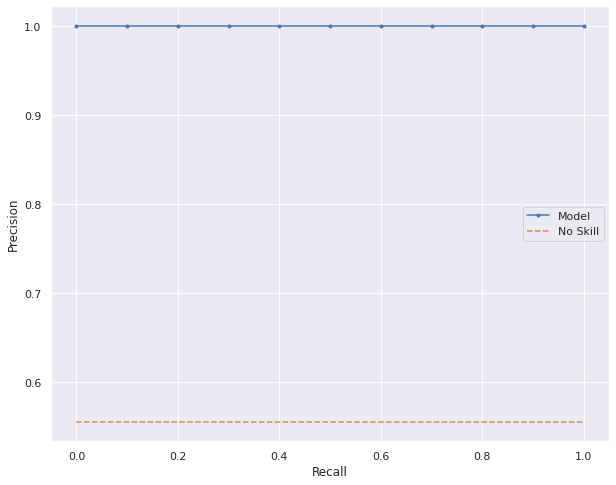




ROC AUC=1.000 



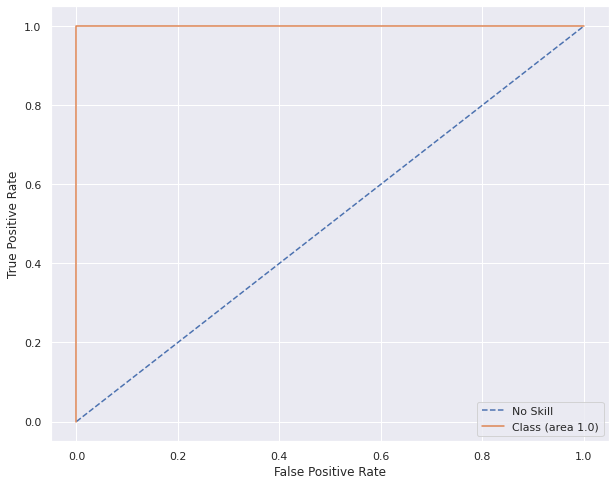


Evaluation Curves


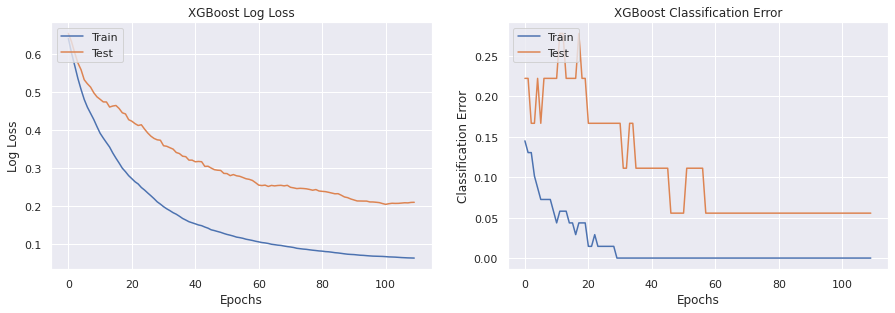



Cohen's kappa: 88.61%




In [77]:
print(f"\nThe precision of the model is {round(100*precision_score(valid_y_sw, pred, labels = LBL),2)}%")
Metric.precision_recall_curve(xgbs,  xvalid_count,  valid_y_sw, LBL, gb=True)
print("\n")
Metric.roc_auc_curve(xgbs, xvalid_count, valid_y_sw,  LBL, gb=True)
print("\nEvaluation Curves")
Metric.plot_eval_xgb(xgbs,  LBL)
print(f"\n\nCohen's kappa: {round(100*cohen_kappa_score(valid_y,  xgbs.predict(xvalid_count)),2)}%\n\n")

XG Boost for TF_IDF


XGBoost for TF_IDF


Accuracy: 100.00%

Classification Report

              precision    recall  f1-score   support

 Non_Abusive       1.00      1.00      1.00         8
     Abusive       1.00      1.00      1.00        10

    accuracy                           1.00        18
   macro avg       1.00      1.00      1.00        18
weighted avg       1.00      1.00      1.00        18


Confusion Matrix



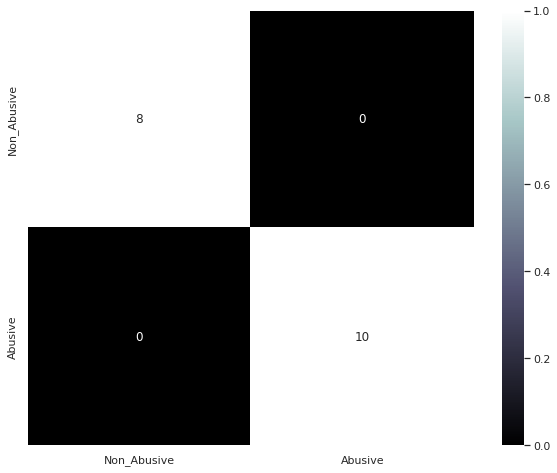

In [78]:
print("\nXGBoost for TF_IDF\n")
xgbs, pred, accuracy = xgb_model(xtrain_tfidf, train_y, xvalid_tfidf, valid_y, labels=labels)
print("\nClassification Report\n")
print(classification_report(valid_y, pred, target_names=LBL))
cm = confusion_matrix(valid_y_sw, pred)
print("\nConfusion Matrix\n")
Metric.plot_confusion_matrix(cm, LBL)


The precision of the model is 100.0%


Model: f1-score=1.000 AUC=1.000




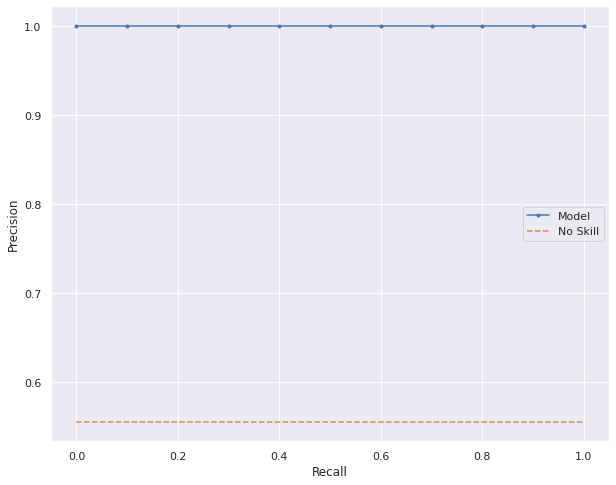




ROC AUC=1.000 



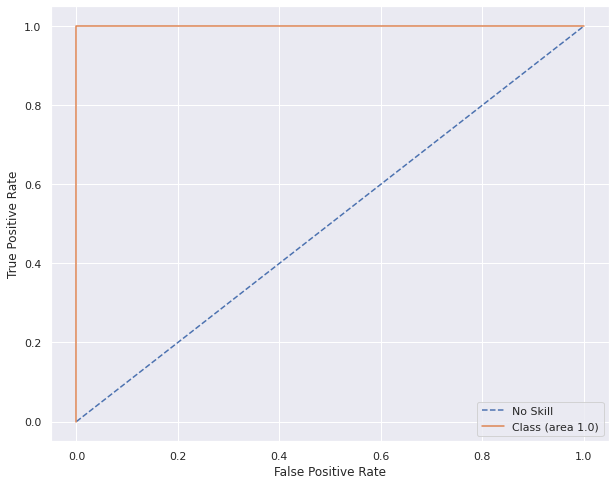


Evaluation Curves


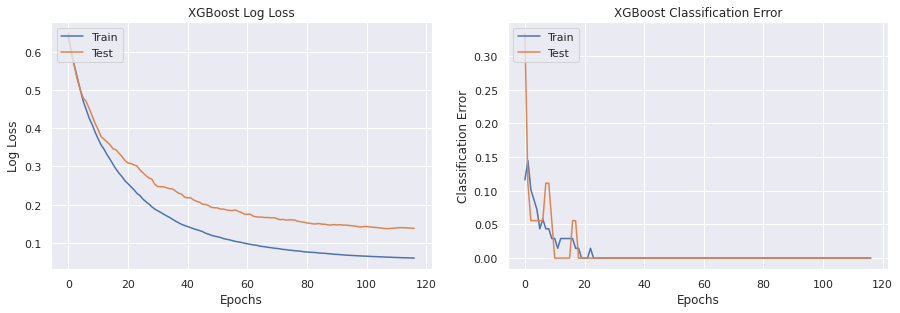



Cohen's kappa: 100.0%




In [79]:
print(f"\nThe precision of the model is {round(100*precision_score(valid_y_sw, pred, labels = LBL),2)}%")
Metric.precision_recall_curve(xgbs,  xvalid_tfidf, valid_y,  LBL,gb=True)
print("\n")
Metric.roc_auc_curve(xgbs,  xvalid_tfidf, valid_y, LBL, gb=True)
print("\nEvaluation Curves")
Metric.plot_eval_xgb(xgbs, LBL)
print(f"\n\nCohen's kappa: {round(100*cohen_kappa_score(valid_y,  xgbs.predict(xvalid_tfidf)),2)}%\n\n")

XG Boost for TF_IDF N Grams


XGBoost for TF_IDF ngram


Accuracy: 83.33%

Classification Report

              precision    recall  f1-score   support

 Non_Abusive       0.78      0.88      0.82         8
     Abusive       0.89      0.80      0.84        10

    accuracy                           0.83        18
   macro avg       0.83      0.84      0.83        18
weighted avg       0.84      0.83      0.83        18


Confusion Matrix



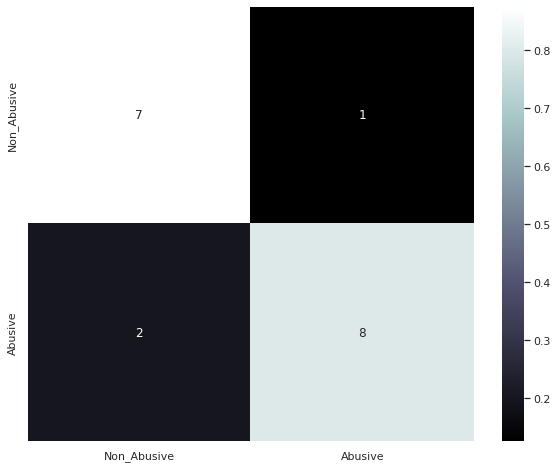

In [80]:
print("\nXGBoost for TF_IDF ngram\n")
xgbs, pred, accuracy = xgb_model(xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram, valid_y, labels=LBL)
print("\nClassification Report\n")
print(classification_report(valid_y, pred, target_names=LBL))
cm = confusion_matrix(valid_y, pred)
print("\nConfusion Matrix\n")
Metric.plot_confusion_matrix(cm, LBL)


The precision of the model is 88.89%


Model: f1-score=0.842 AUC=0.875




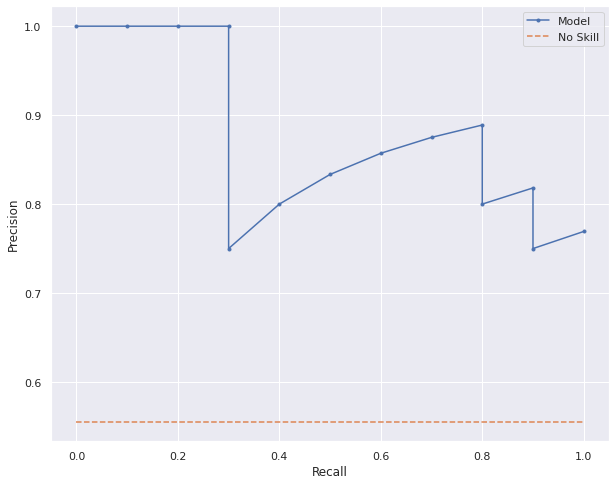




ROC AUC=0.875 



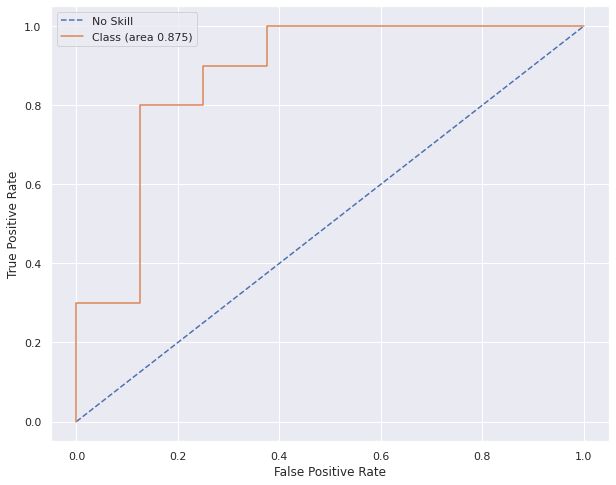


Evaluation Curves


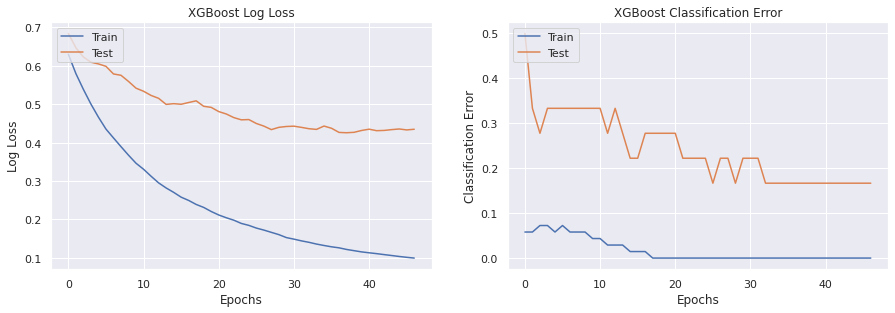



Cohen's kappa: 66.67%




In [81]:
print(f"\nThe precision of the model is {round(100*precision_score(valid_y, pred, labels = LBL),2)}%")
Metric.precision_recall_curve(xgbs,  xvalid_tfidf_ngram, valid_y, LBL, gb=True)
print("\n")
Metric.roc_auc_curve(xgbs,  xvalid_tfidf_ngram, valid_y, LBL, gb=True)
print("\nEvaluation Curves")
Metric.plot_eval_xgb(xgbs,  LBL)
print(f"\n\nCohen's kappa: {round(100*cohen_kappa_score(valid_y,  xgbs.predict(xvalid_tfidf_ngram)),2)}%\n\n")

XG Boost for TF-IDF-N Grams - Characters


XGBoost for TF-IDF ngram chars


Accuracy: 88.89%

Classification Report

              precision    recall  f1-score   support

 Non_Abusive       0.88      0.88      0.88         8
     Abusive       0.90      0.90      0.90        10

    accuracy                           0.89        18
   macro avg       0.89      0.89      0.89        18
weighted avg       0.89      0.89      0.89        18


Confusion Matrix



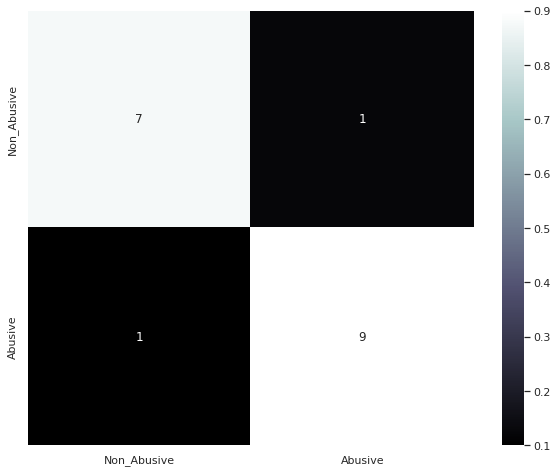

In [82]:
print("\nXGBoost for TF-IDF ngram chars\n")
xgbs, pred, accuracy = xgb_model(xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars, valid_y, labels=LBL)
print("\nClassification Report\n")
print(classification_report(valid_y, pred,target_names=LBL))
cm = confusion_matrix(valid_y, pred)
print("\nConfusion Matrix\n")
Metric.plot_confusion_matrix(cm, LBL)


The precision of the model is 90.0%


Model: f1-score=0.900 AUC=0.976




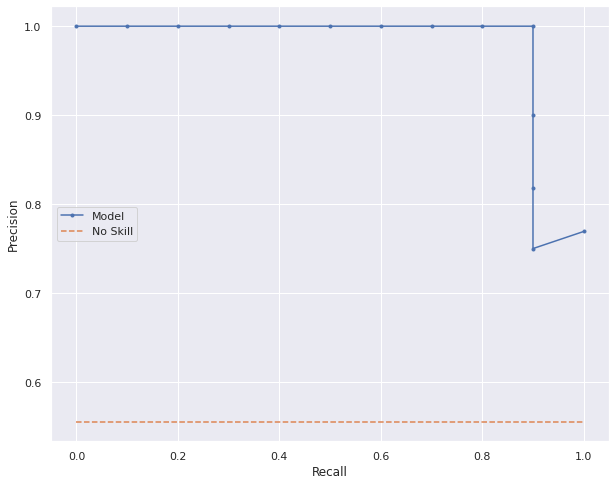




ROC AUC=0.963 



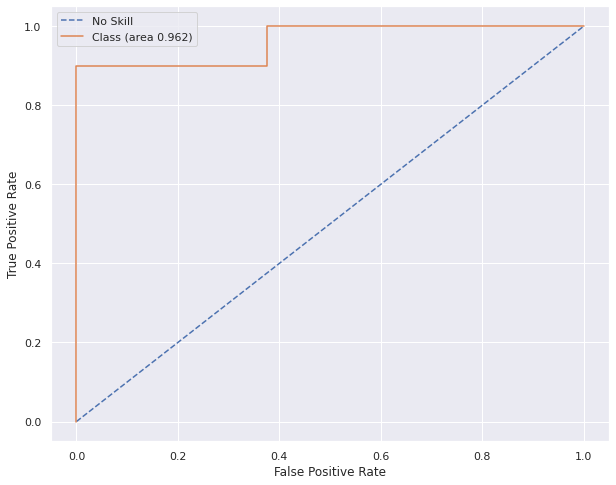


Evaluation Curves


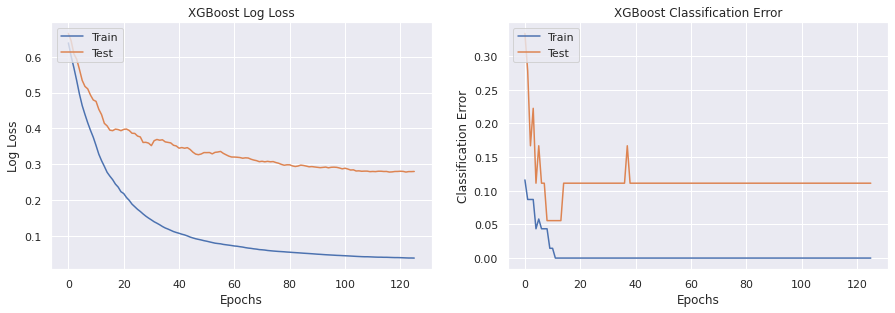



Cohen's kappa: 77.5%




In [83]:
print(f"\nThe precision of the model is {round(100*precision_score(valid_y, pred, labels = LBL),2)}%")
Metric.precision_recall_curve(xgbs,  xvalid_tfidf_ngram_chars, valid_y, LBL, gb=True)
print("\n")
Metric.roc_auc_curve(xgbs,  xvalid_tfidf_ngram_chars, valid_y, LBL, gb=True)
print("\nEvaluation Curves")
Metric.plot_eval_xgb(xgbs,  LBL)
print(f"\n\nCohen's kappa: {round(100*cohen_kappa_score(valid_y,  xgbs.predict(xvalid_tfidf_ngram_chars)),2)}%\n\n")